In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [2]:
mergedData = pd.read_excel('TabellaFinale.xlsx', sheet_name=None)

In [3]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0           7      2236     M   64 2021-02-26 00:00:00        27.30       422   
1           6      6426     M   47 2021-04-02 00:00:00         2.56       457   
2          18      8377     M   56 2020-08-31 00:00:00         7.80       243   
3          51     11463     M   71 2020-08-31 00:00:00        24.74       243   
4          53     11463     M   71 2021-03-31 10:54:33          NaN       456   

   num_visita  Charlson_Totale Charlson_Diabete  ...  DASS21 stress  \
0           0              NaN              NaN  ...            0.0   
1           0              2.0           0 = No  ...            3.0   
2           0              1.0           0 = No  ...            NaN   
3           0              3.0           0 = No  ...            NaN   
4           1              NaN              NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level  SF36 general health Resilience  
0               Subthreshold Insomnia                 75.0       64.0  
1  No Clinically Significant Insomnia                 10.0       54.0  
2                                 NaN                  NaN        NaN  
3                                 NaN                  NaN        NaN  
4  No Clinically Significant Insomnia                 90.0       88.0  

[5 rows x 80 columns]

In [4]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [5]:
df.head()

HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  num_visita  \
0      2236     M   64 2021-02-26 00:00:00        27.30       422           0   
1      6426     M   47 2021-04-02 00:00:00         2.56       457           0   
2      8377     M   56 2020-08-31 00:00:00         7.80       243           0   
3     11463     M   71 2020-08-31 00:00:00        24.74       243           0   
4     11463     M   71 2021-03-31 10:54:33          NaN       456           1   

   Charlson_Totale Charlson_Diabete  Stifness  ...  DASS21 stress  \
0              NaN              NaN       6.7  ...            0.0   
1              2.0           0 = No       NaN  ...            3.0   
2              1.0           0 = No       NaN  ...            NaN   
3              3.0           0 = No       NaN  ...            NaN   
4              NaN              NaN       NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level SF36 general health Resilience  
0               Subthreshold Insomnia                75.0       64.0  
1  No Clinically Significant Insomnia                10.0       54.0  
2                                 NaN                 NaN        NaN  
3                                 NaN                 NaN        NaN  
4  No Clinically Significant Insomnia                90.0       88.0  

[5 rows x 79 columns]

In [6]:
dfSenzaData = df.drop(columns=['DATA', 'num_visita', 'DATA_INT'])

In [7]:

#dfSenzaData.to_excel('TabellaFinaleSenzaData.xlsx')

In [8]:
dfSenzaData = dfSenzaData[(dfSenzaData['FrailtyPhenotypeBool'].notna()) & (dfSenzaData['Resilience'].notna())]

In [9]:
soloETA = dfSenzaData[['HDN_CODE','Alcool', 'Fumatore', 'FrailtyPhenotypeBool', 'PersoPeso']]
dfSenzaData.to_csv('TabellaFinaleSenzaDataIndependentParziale.csv')
#soloETA = dfSenzaData[['HDN_CODE','ETA']]

In [10]:
#soloETA.to_csv('SoloETA.csv')

## Parametri utente

In [11]:
input_data = 'TabellaFinaleSenzaDataIndependentParziale.csv' 
mode = 'correlated_attribute_mode'
description_file = 'description_parziale_independent.json'
synthetic_data = 'synthetic_data_correlated.csv'

In [12]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 15

# specify categorical attributes
categorical_attributes = {'Sesso':True,
                            #'num_visita':True,
                            'Charlson_Diabete':True,
                            'Charlson_Totale':True,
                            'FrailtyPhenotypeBool':True,
                            'Pneumo_ScalaBorg':True,
                            'TestCammino6Min_BorgBase':True,
                            'TestCammino6Min_BorgEnd':True,
                            'Alcool':True,
                            'Fumatore':True,
                            'Sintomi_Cadute':True,
                            'Sintomi_DifficoltaDeglutizione':True,
                            'Sintomi_DistUdito':True,
                            'Sintomi_DistVista':True,
                            'SintomiNeuropsico_Ageusia':True,
                            'SintomiNeuropsico_Anosmia':True,
                            'SintomiNeuropsico_Astenia':True,
                            'SintomiNeuropsico_CognitivoAttenzione':True,
                            'SintomiNeuropsico_CognitivoConcentrazione':True,
                            'SintomiNeuropsico_CognitivoMemoria':True,
                            'SintomiNeuropsico_DistEquilibrio':True,
                            'SintomiNeuropsico_DistSonno':True,
                            'SintomiNeuropsico_DoloriMuscolari':True,
                            'SintomiNeuropsico_Effluvium':True,
                            'Descrizione':True,
                            'AssumePiuFarmaciGiorno':True,
                            'PersoPeso':True,
                            'CamminareMenoUltimoAnno':True,
                            'CaduteUltimoAnno':True,
                            'SentirsiSolo':True,
                            'PuoContareSuQualcuno':True,
                            'DifficoltaEconomicheSpeseSanitarie':True,
                            'EQ5D5L health score':True,
                            'DASS21 stress':True,
                            'Anxiety level':True,
                            'DASS21 depression':True,
                            'Depression level':True,
                            'Insomnia severity index':True,
                            'ISI level':True
                         }

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 3

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 1000

In [13]:
# istanzio il data describer
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_independent_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                         #k = degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.describe_dataset_in_random_mode(input_data)
describer.save_dataset_description_to_file(description_file)

In [14]:
#display_bayesian_network(describer.bayesian_network)

In [15]:

generator = DataGenerator()
generator.generate_dataset_in_independent_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [16]:
dfs = pd.read_csv(synthetic_data)

(array([  4.,  10.,  11.,  42.,  81., 108., 119.,  71.,  83.,  22.]),
 array([14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. , 81.5, 89. ]),
 <BarContainer object of 10 artists>)

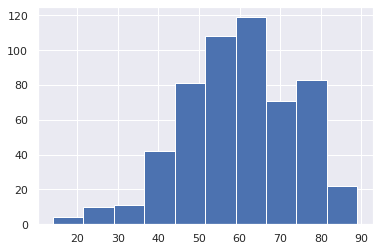

In [17]:
plt.hist(df['ETA'])

(array([ 50.,  43.,  53.,  58.,  44.,  54.,  50.,  41.,  53., 554.]),
 array([17. , 23.9, 30.8, 37.7, 44.6, 51.5, 58.4, 65.3, 72.2, 79.1, 86. ]),
 <BarContainer object of 10 artists>)

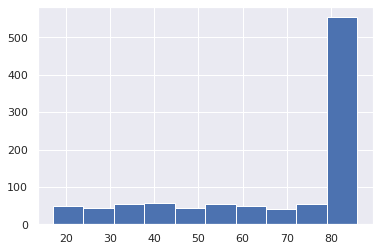

In [18]:
plt.hist(dfs['ETA'])

## Ispector

In [19]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)


/home/gibbo/.local/lib/python3.7/site-packages/DataSynthesizer/ModelInspector.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 5), dpi=120)


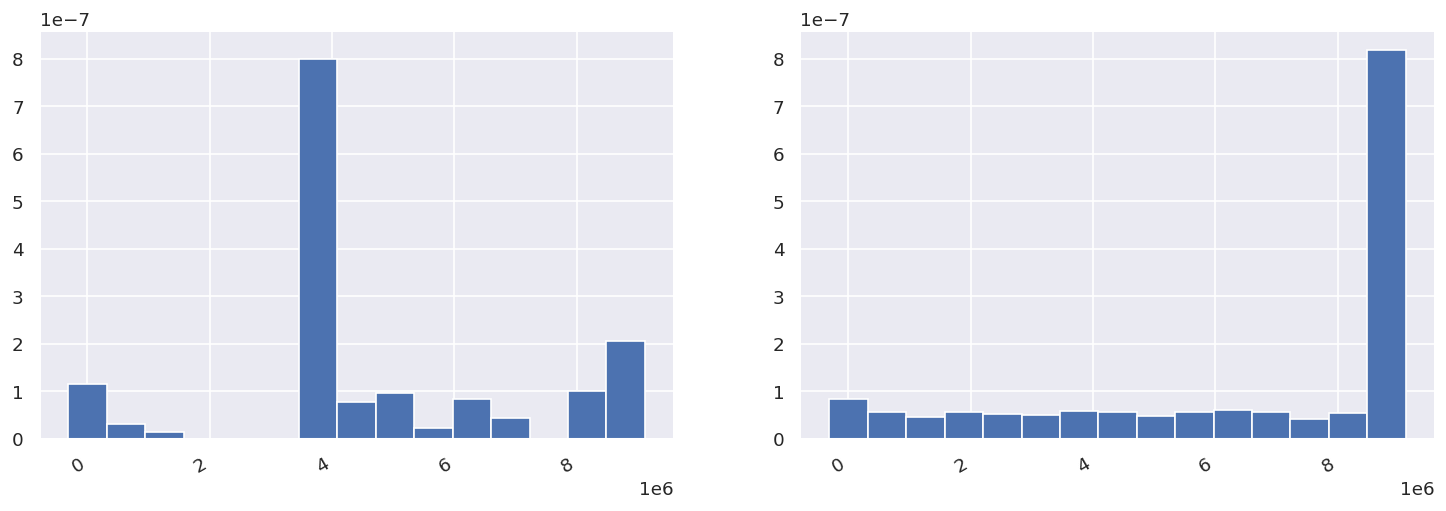

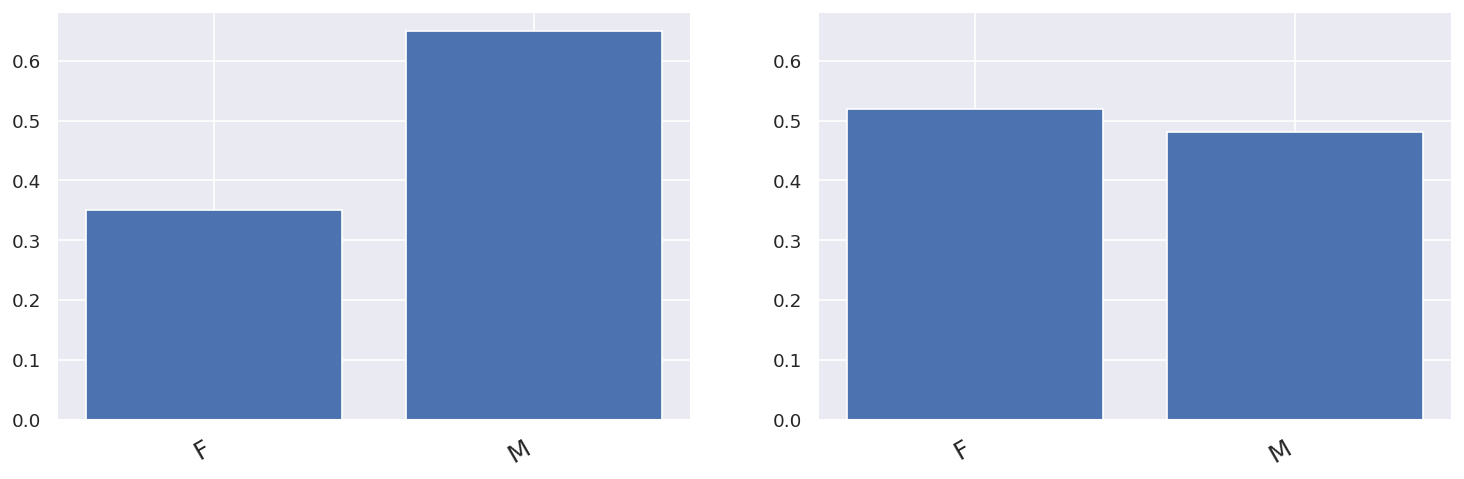

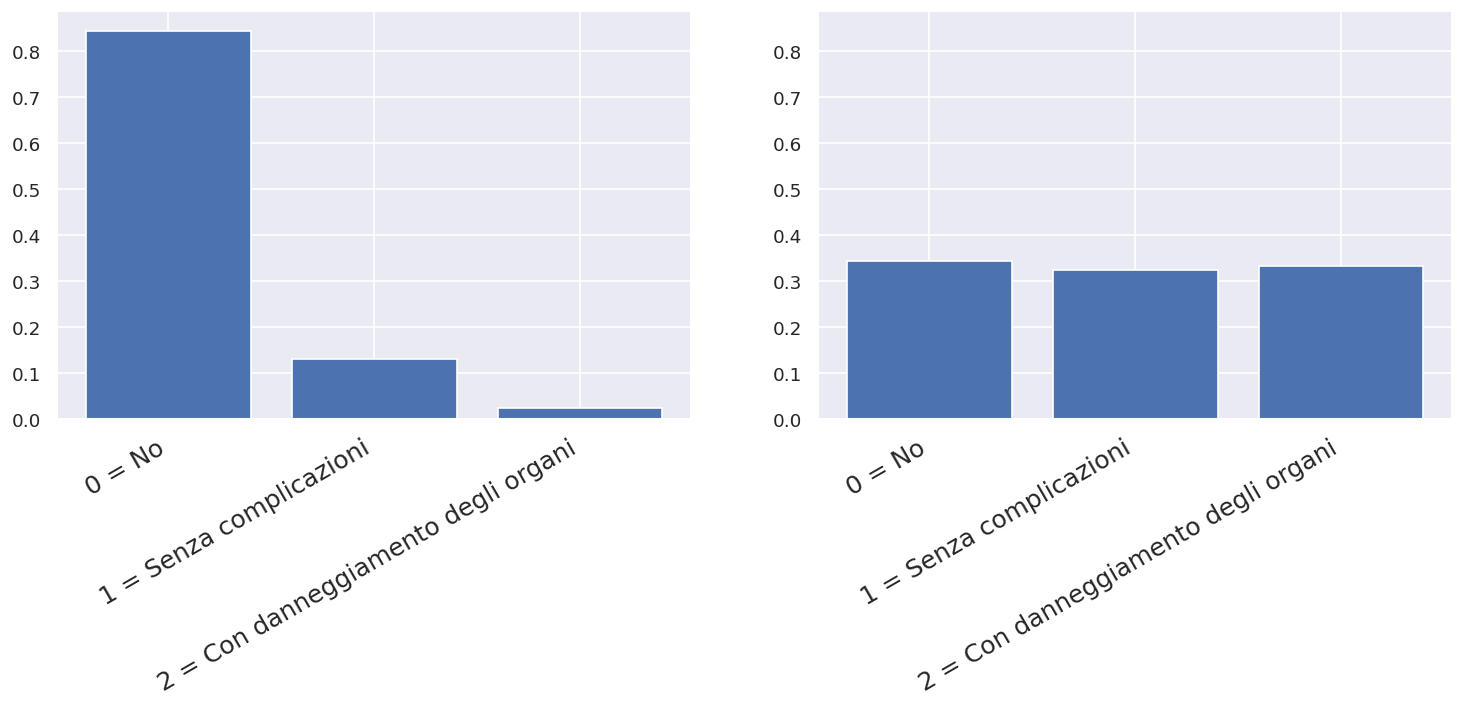

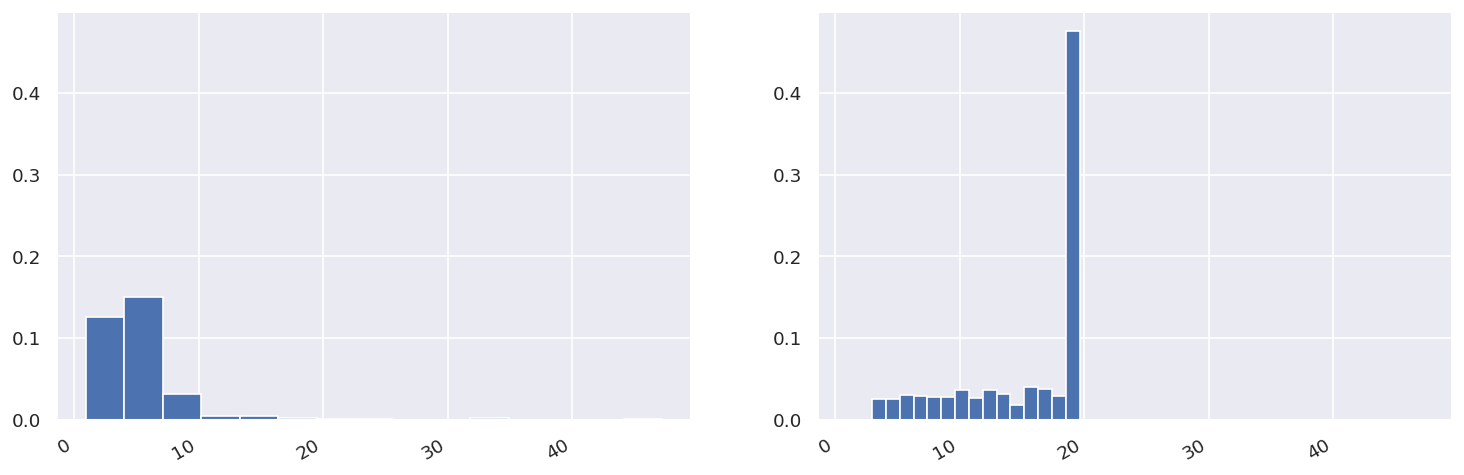

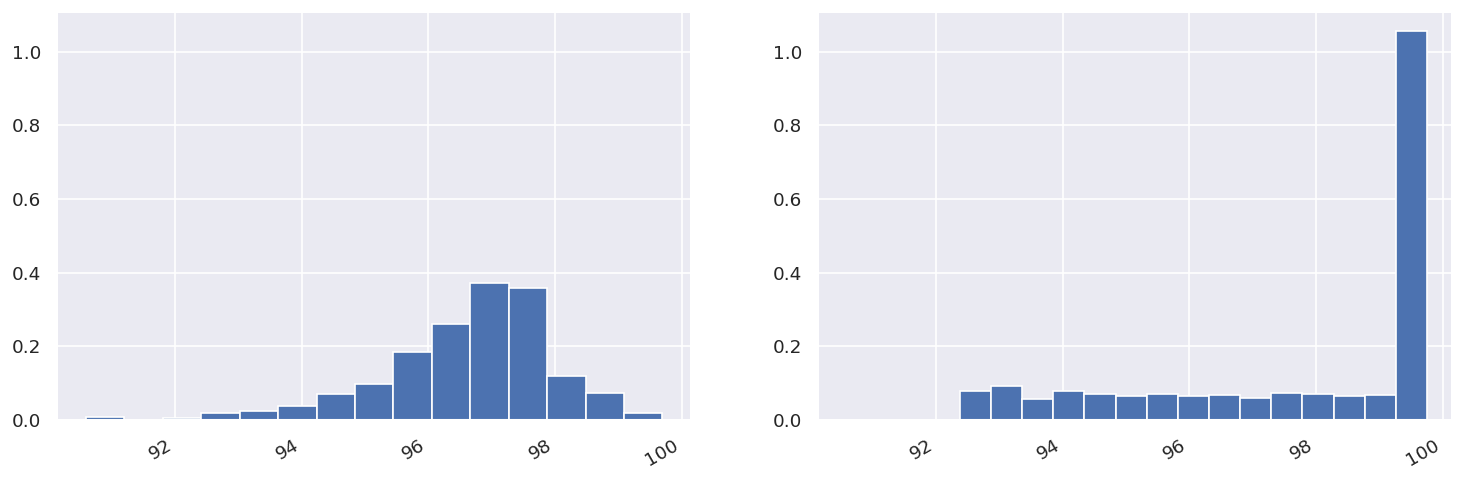

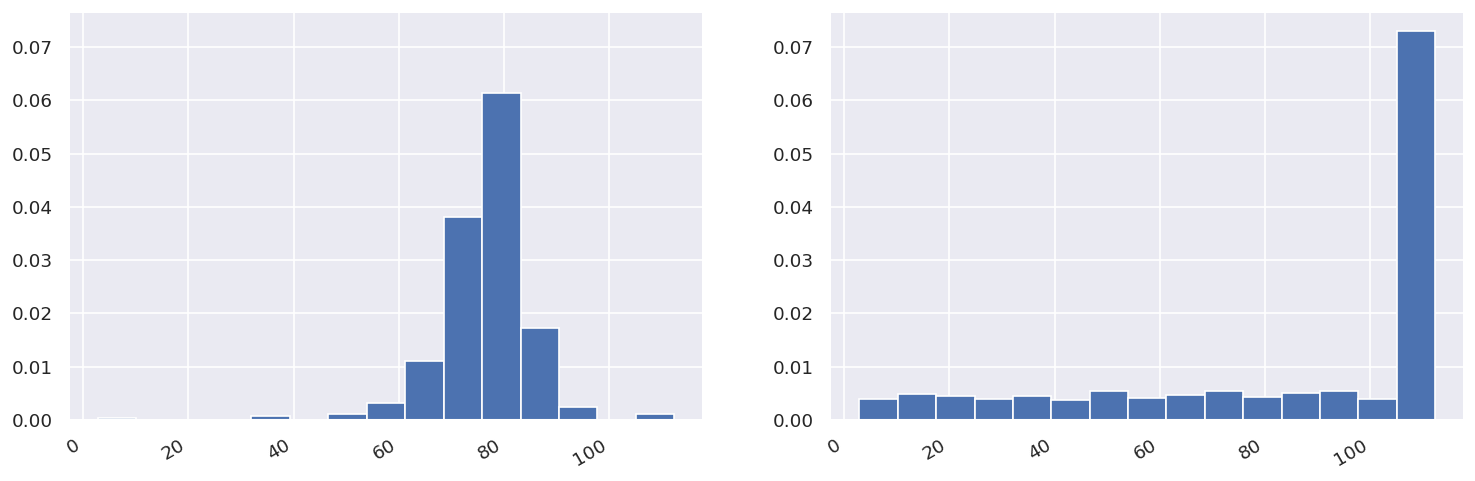

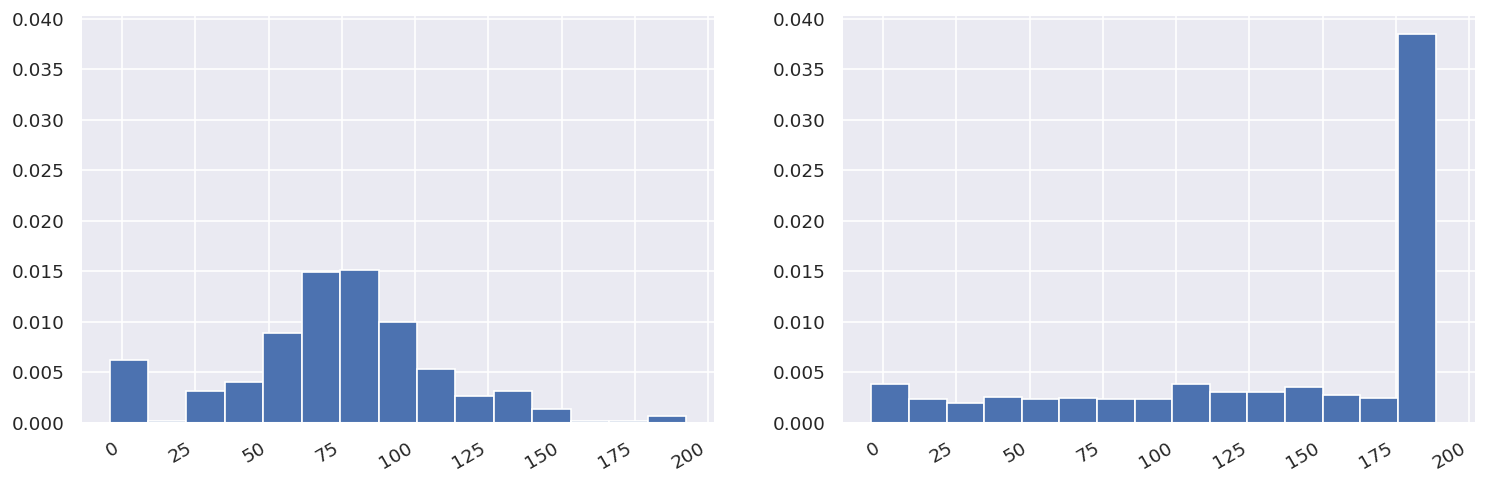

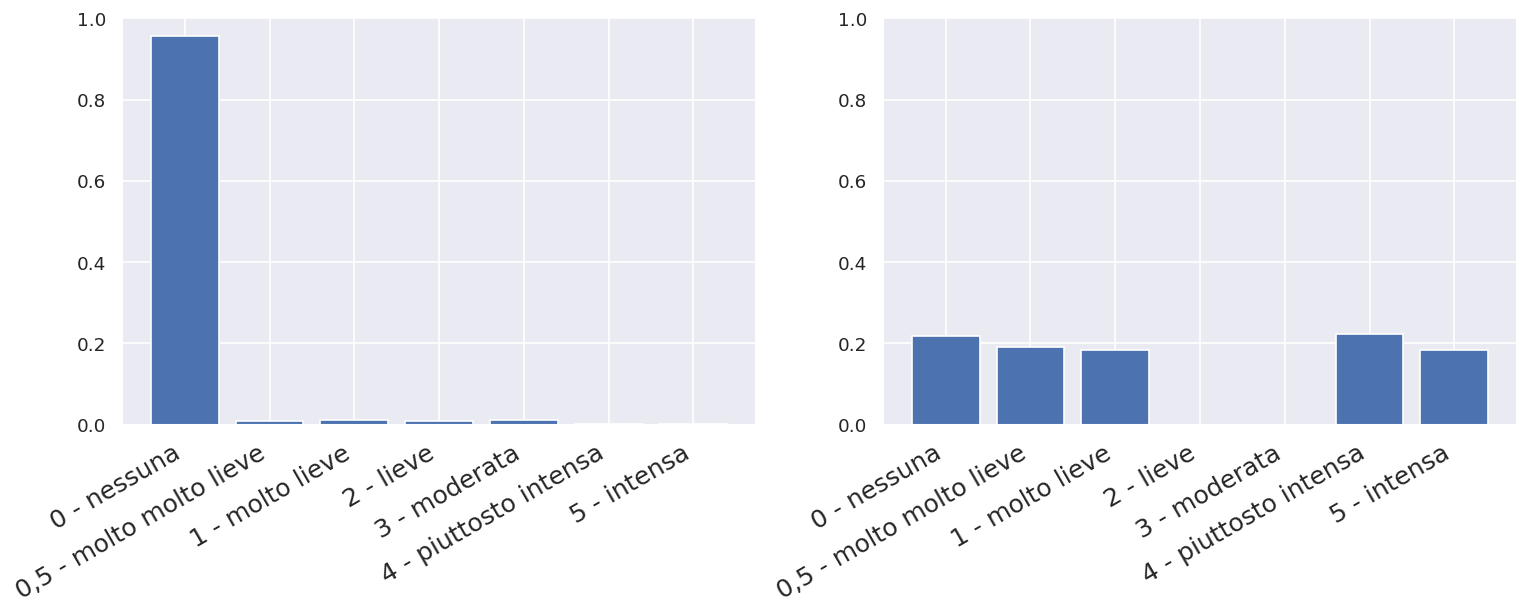

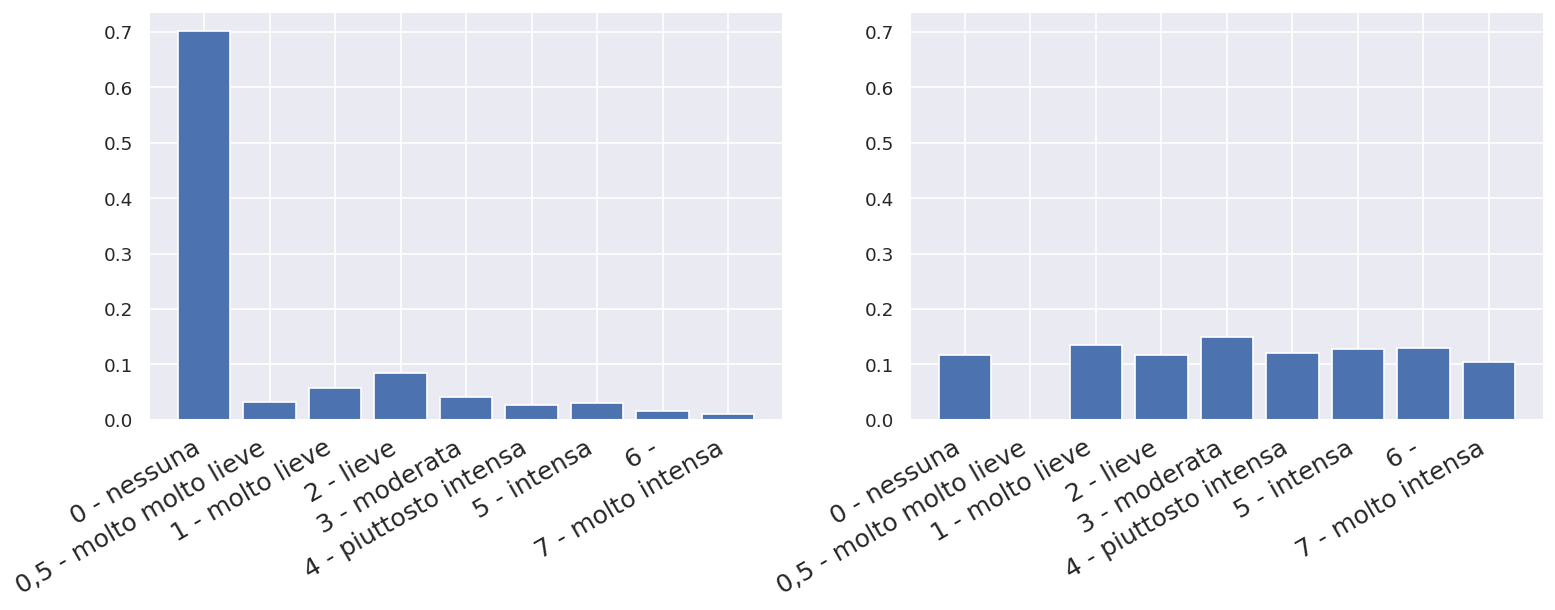

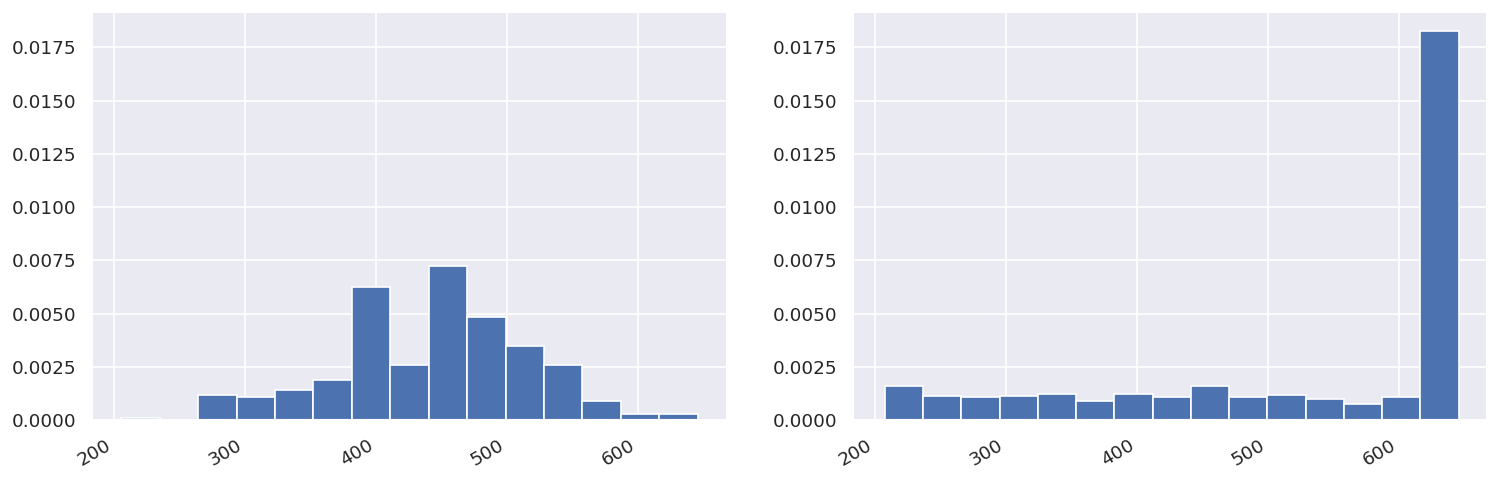

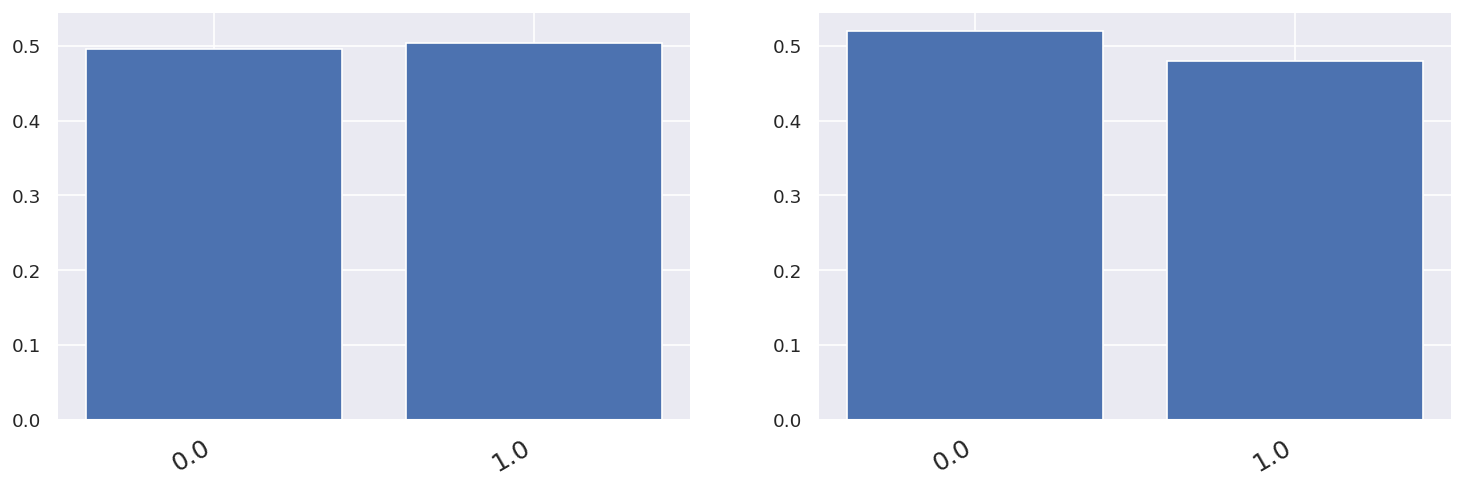

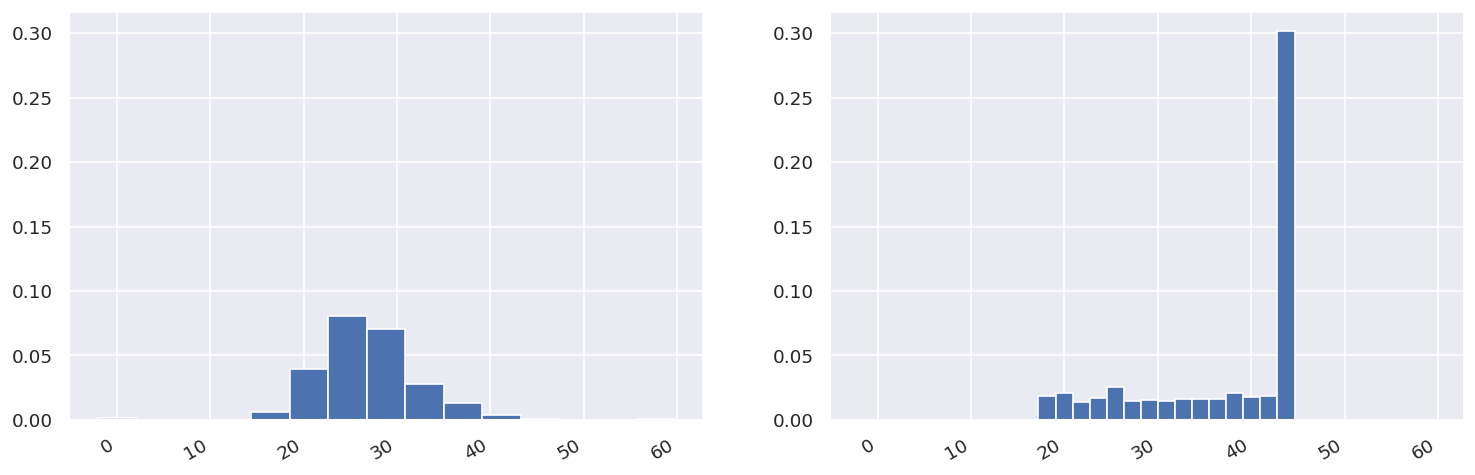

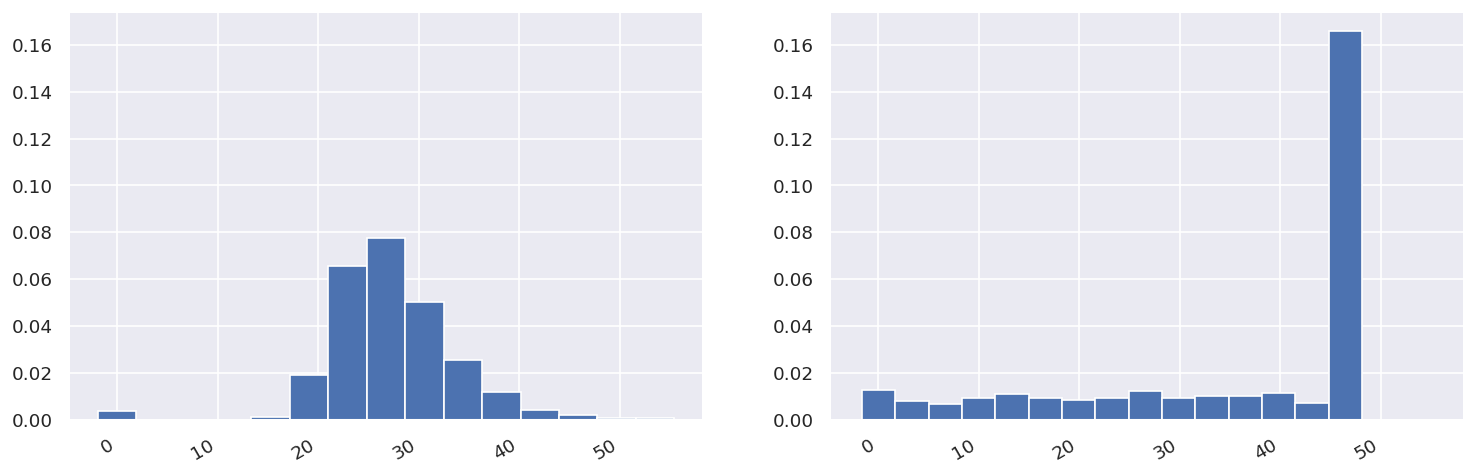

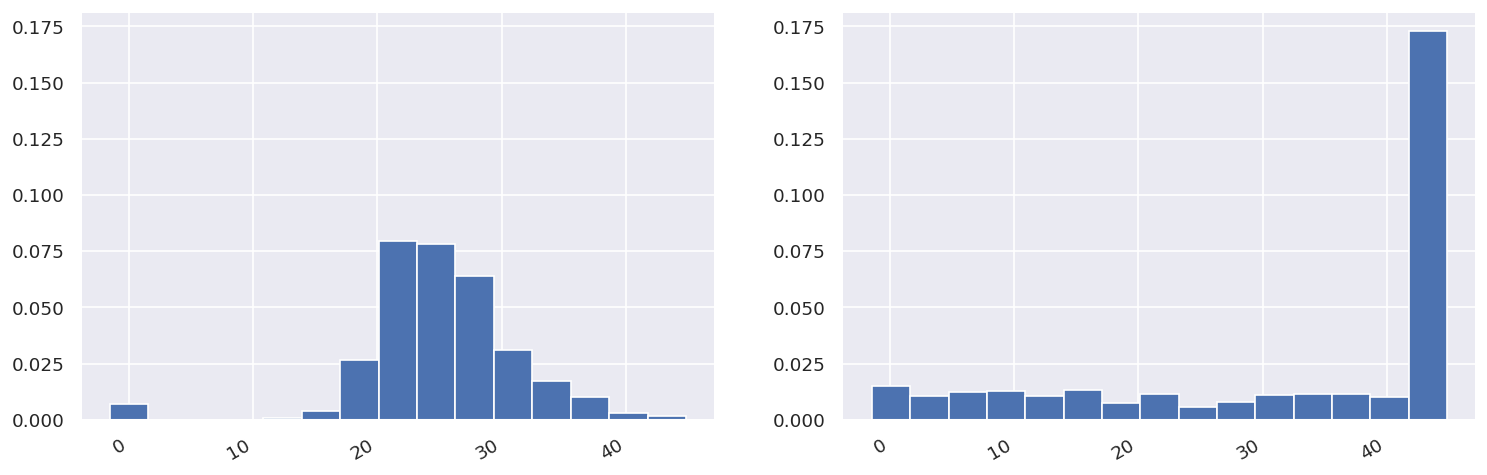

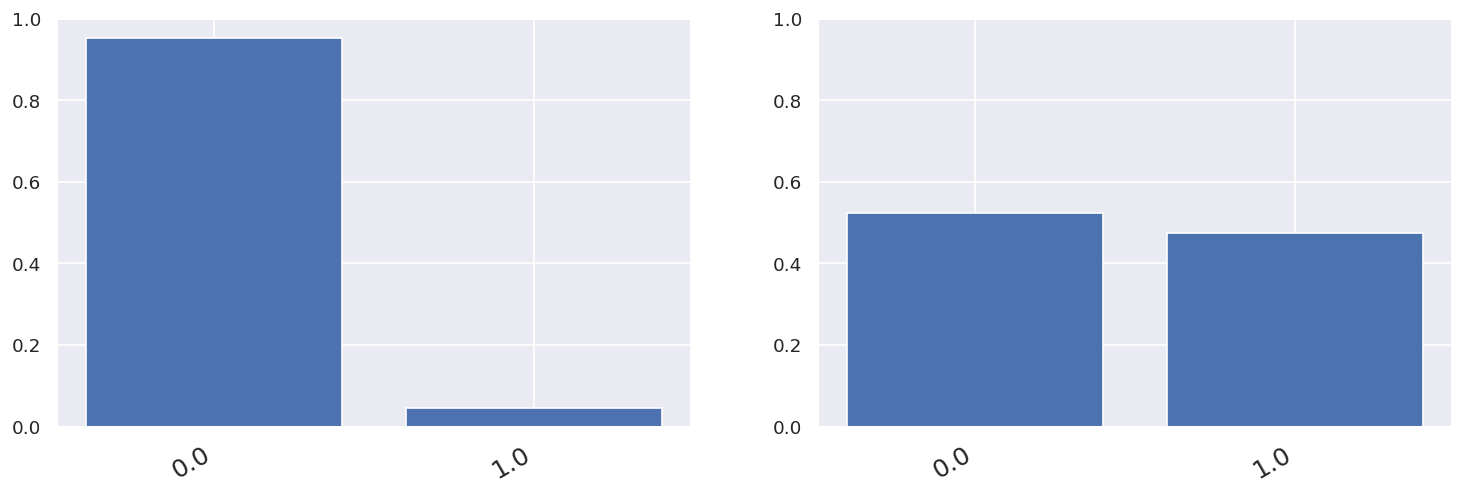

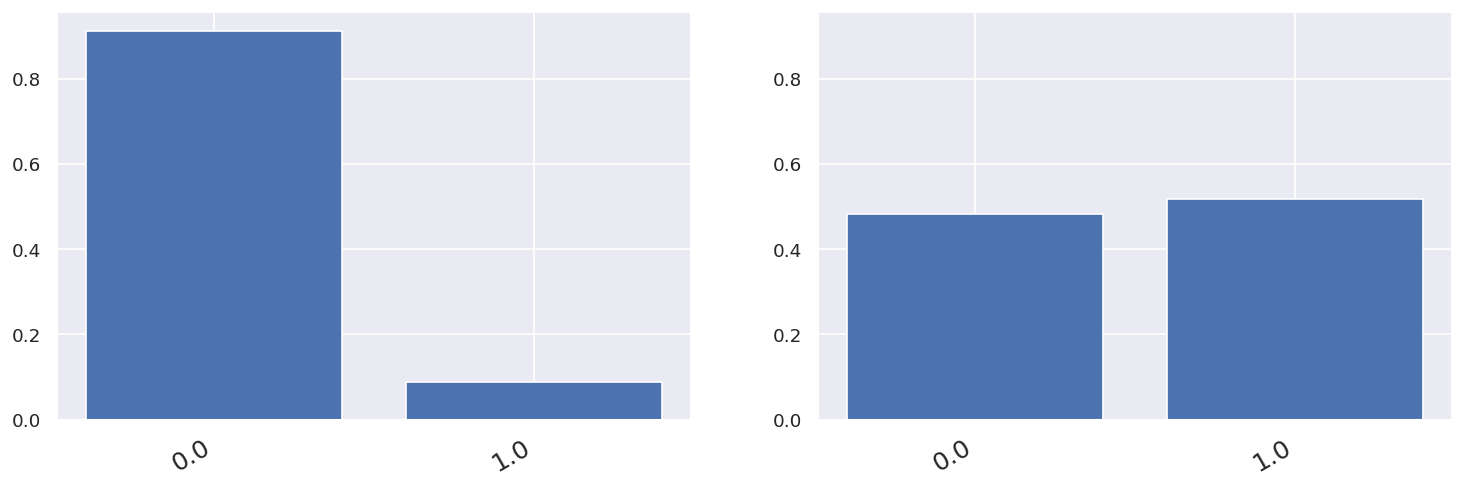

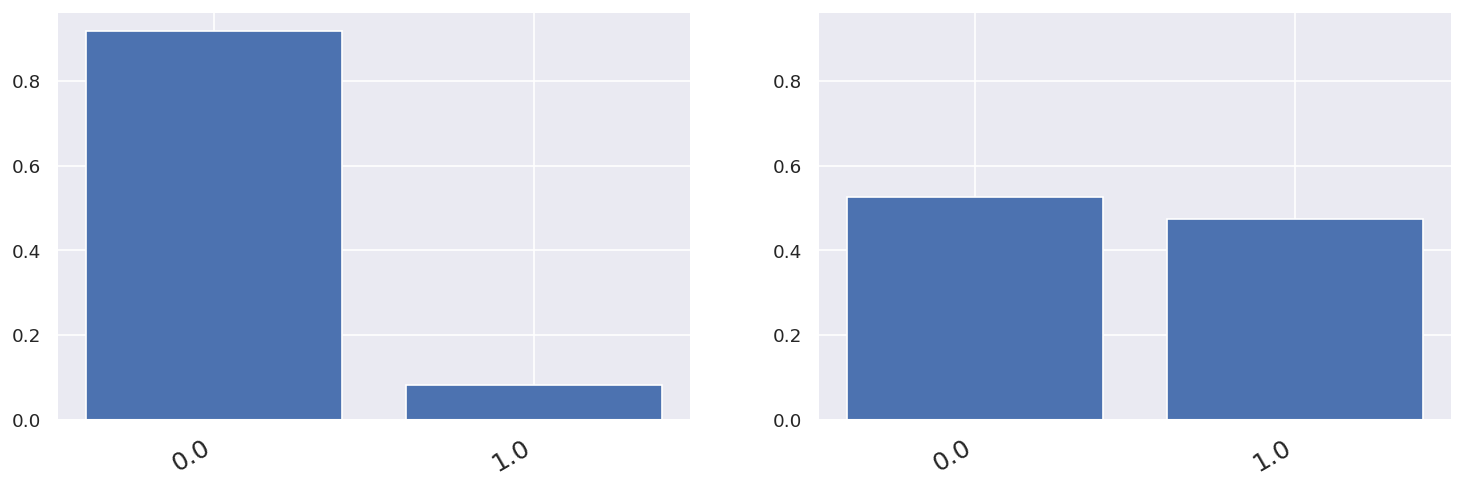

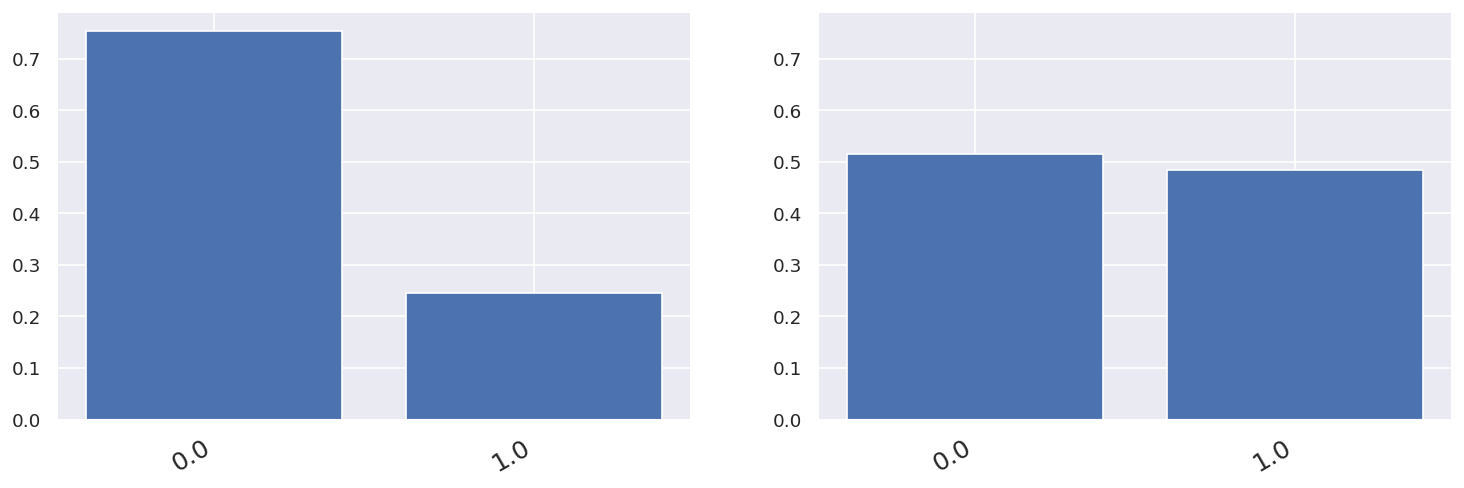

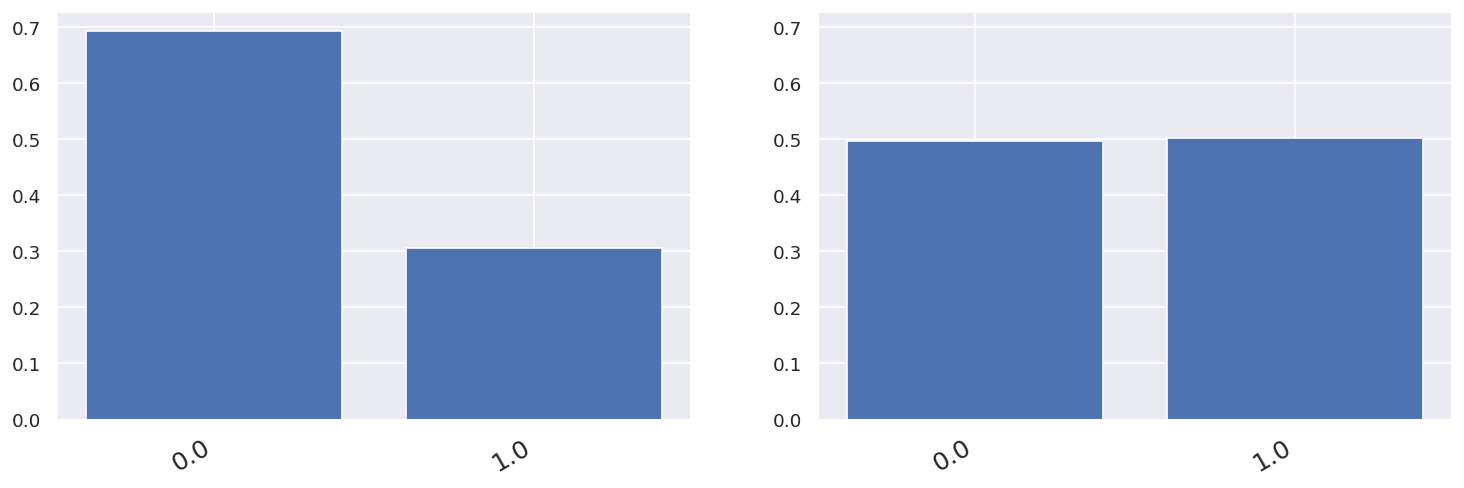

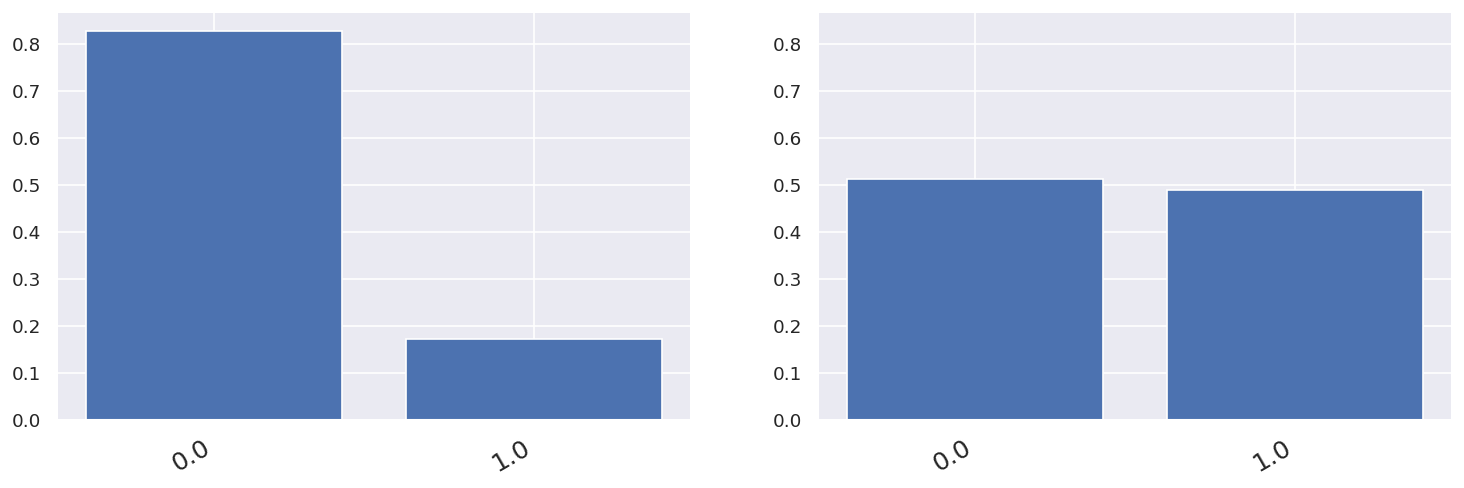

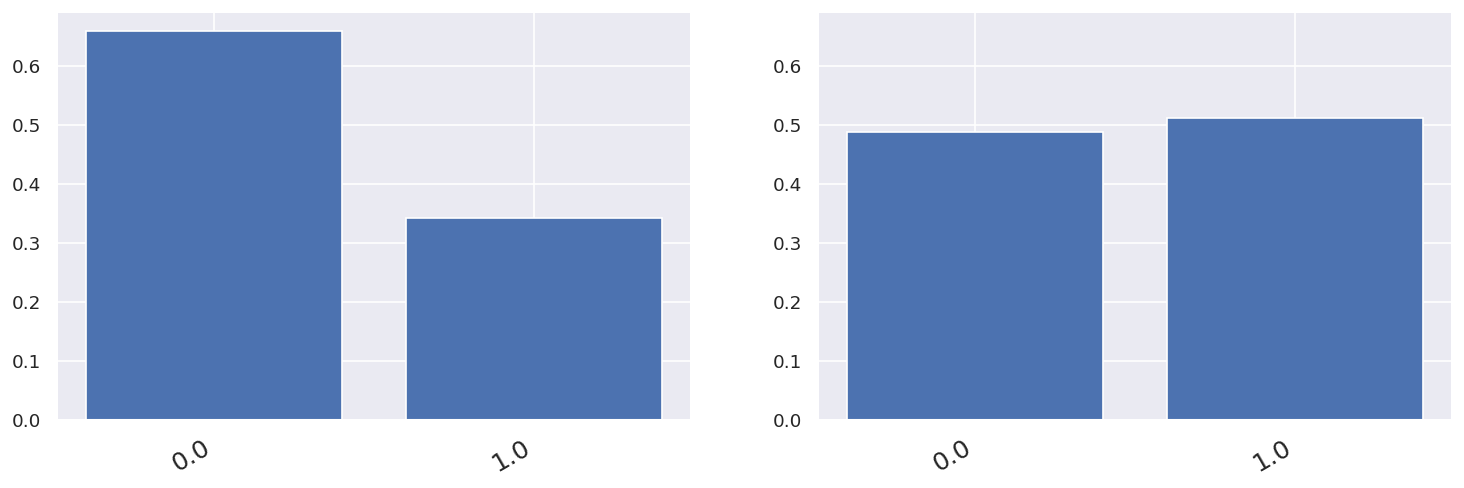

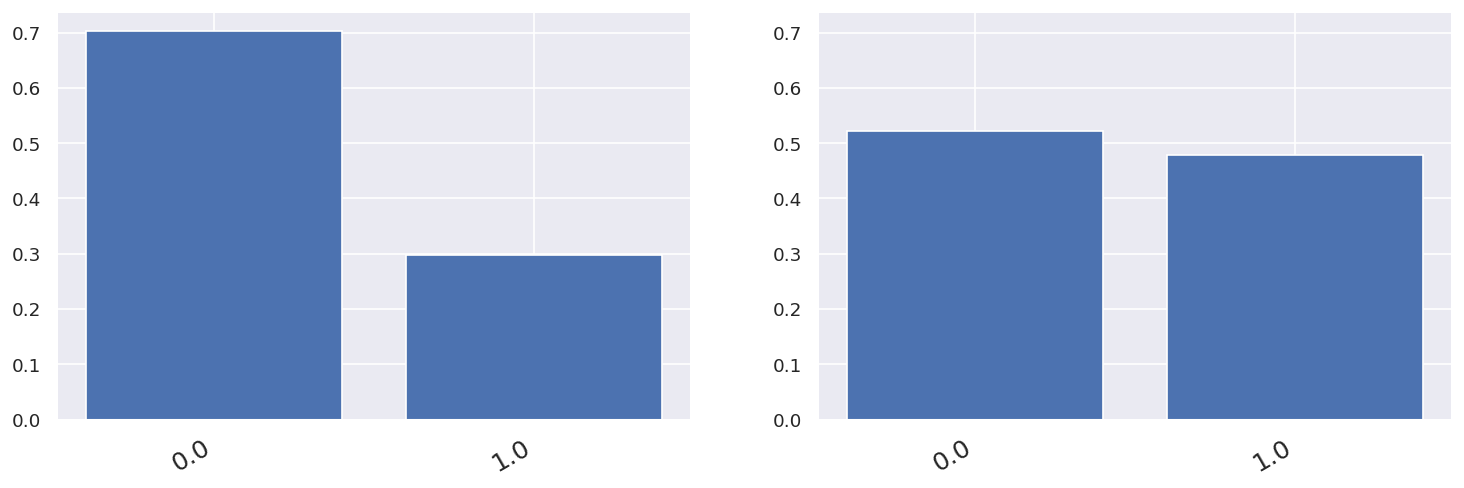

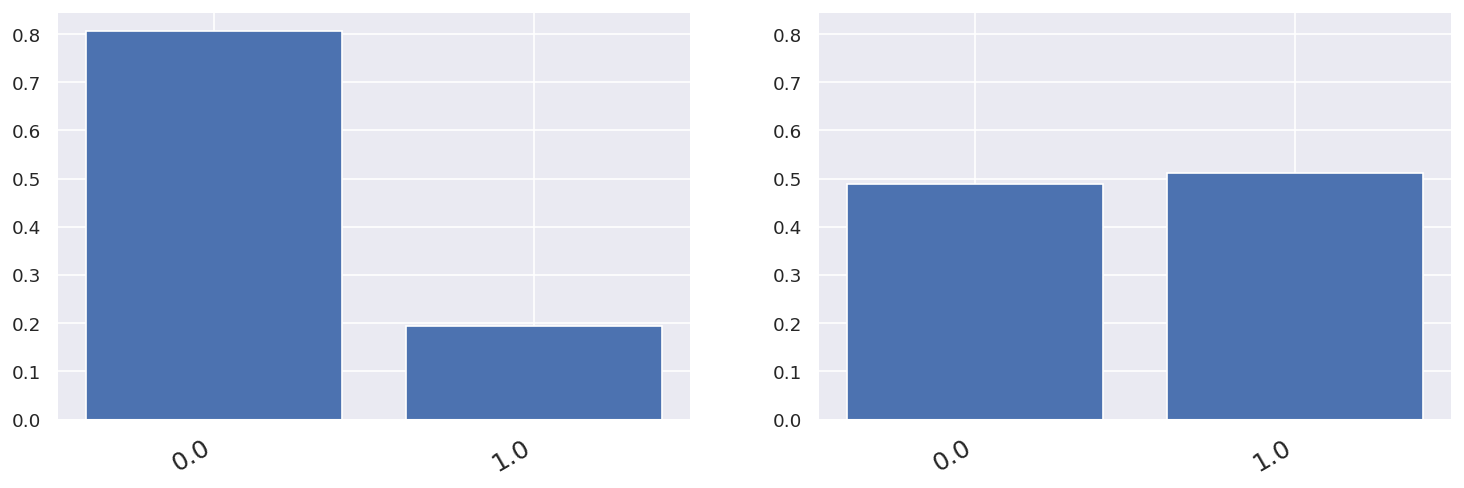

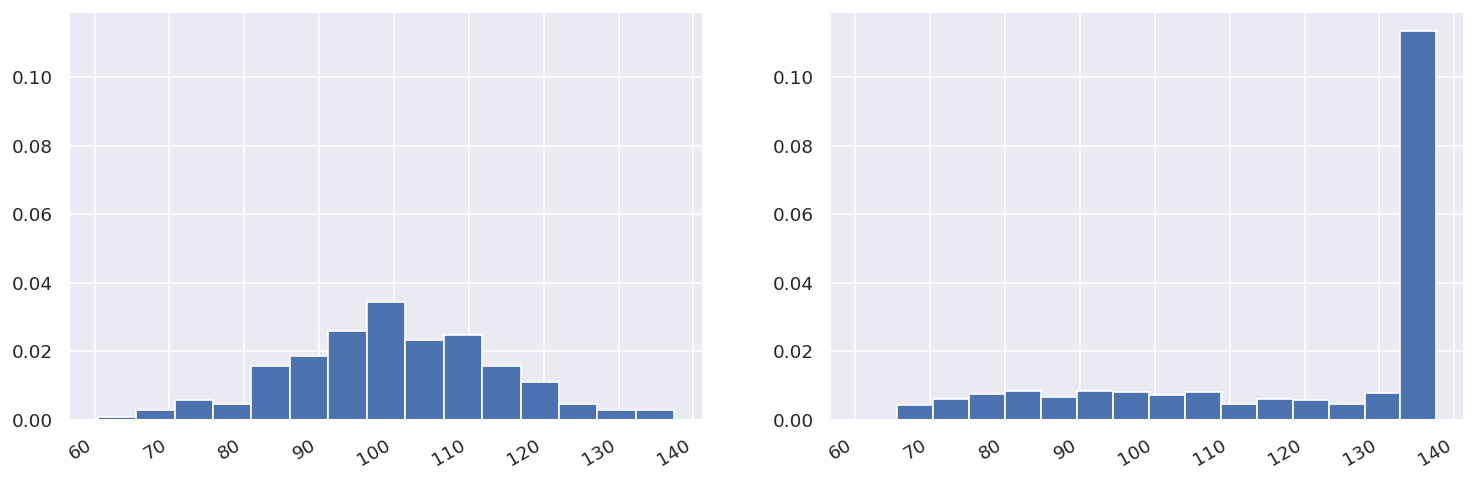

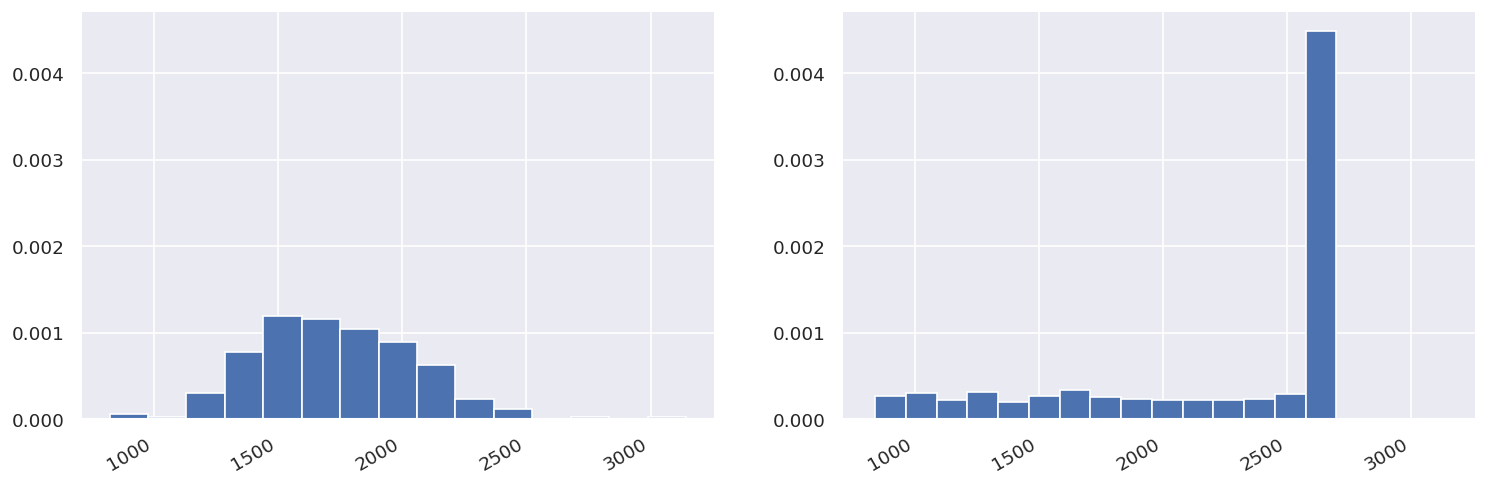

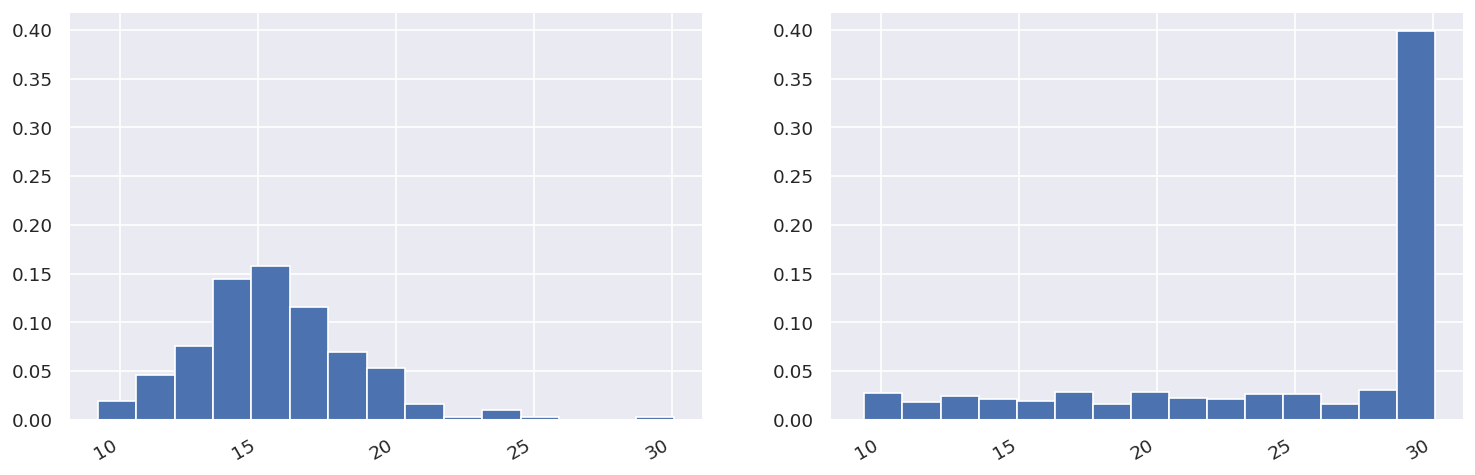

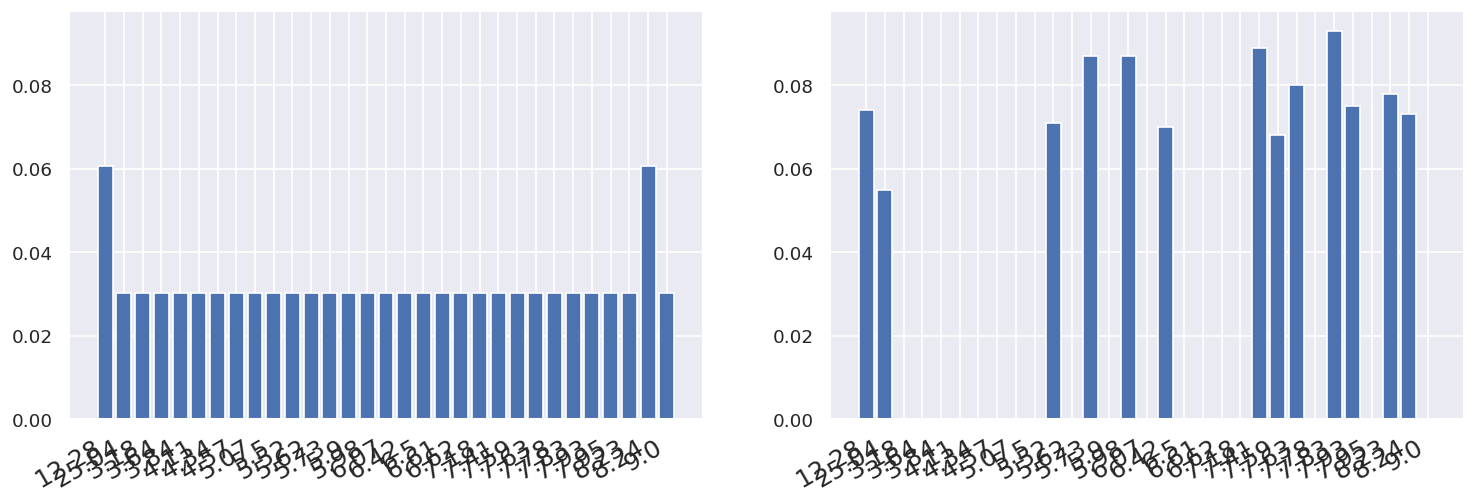

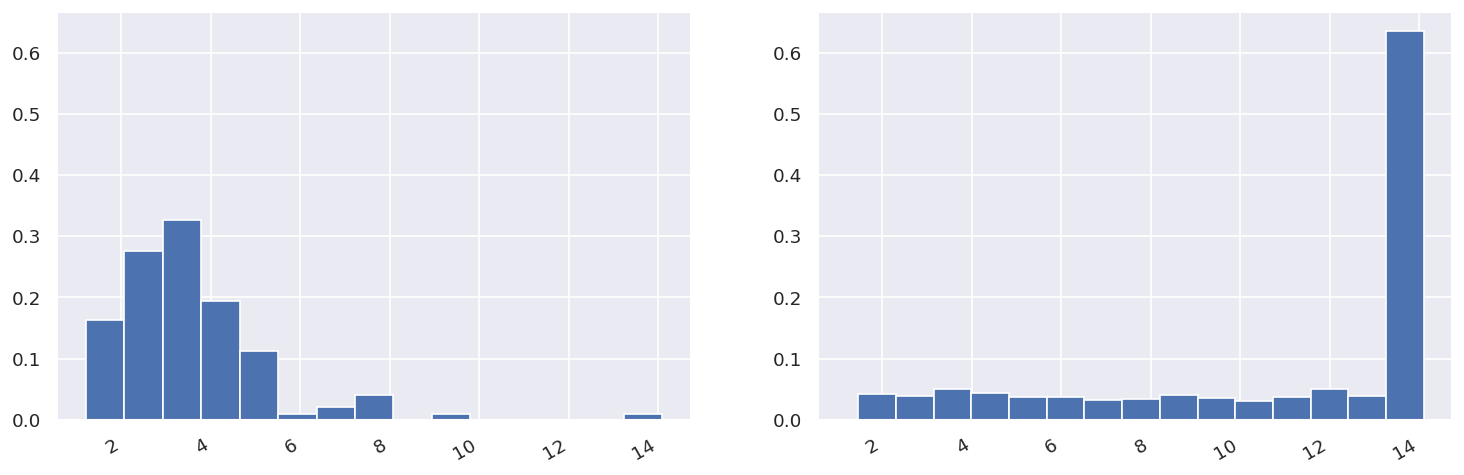

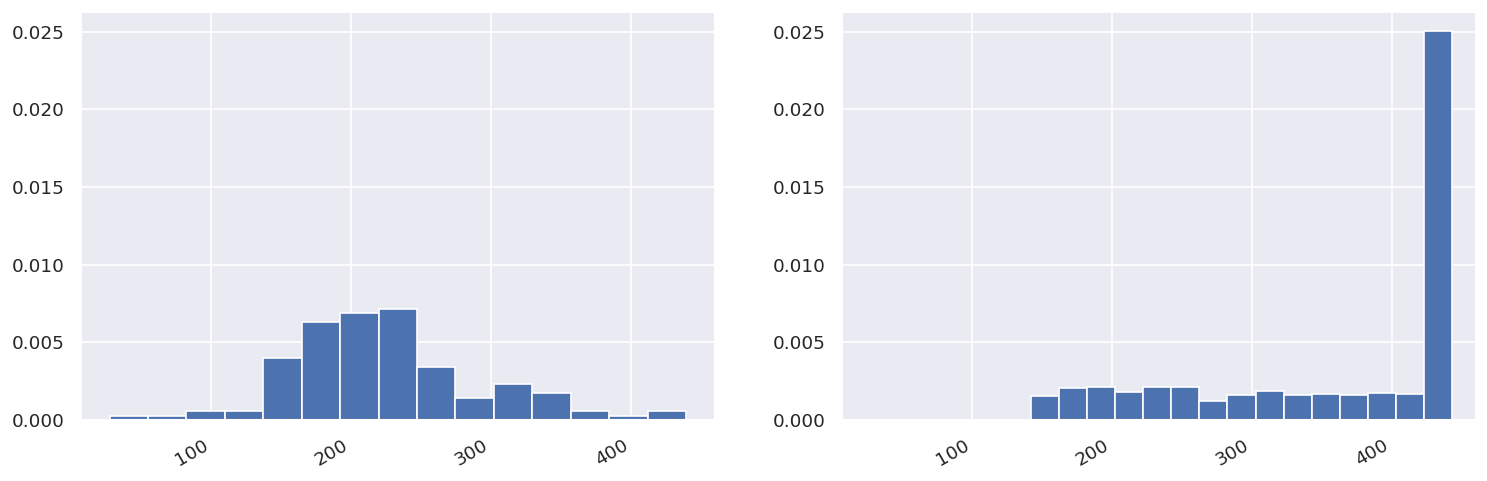

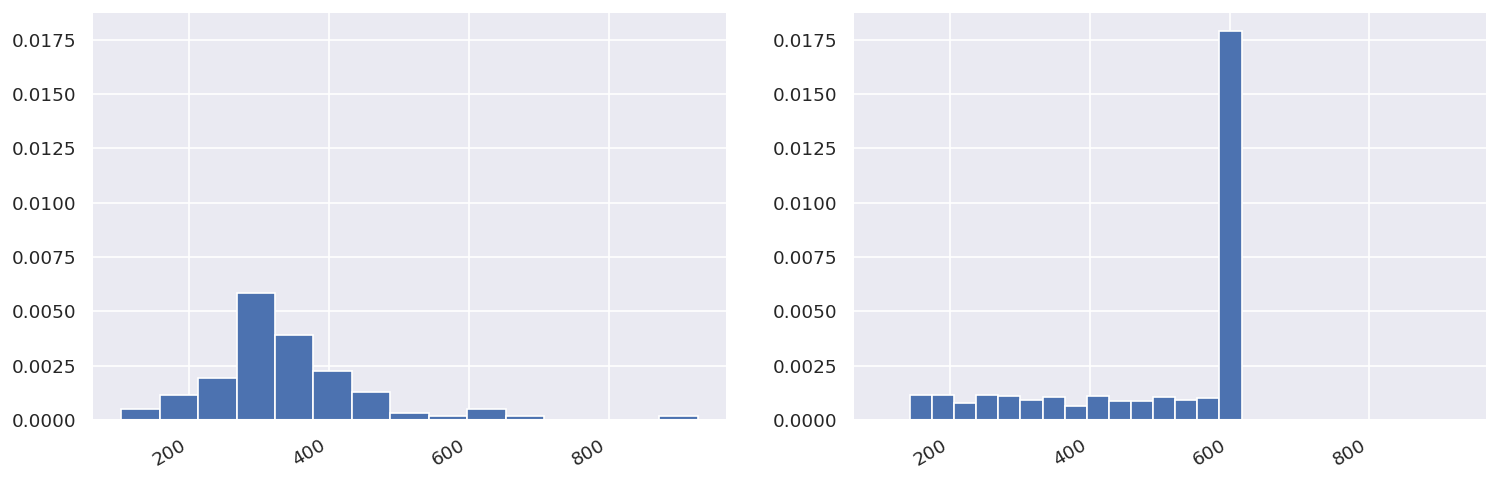

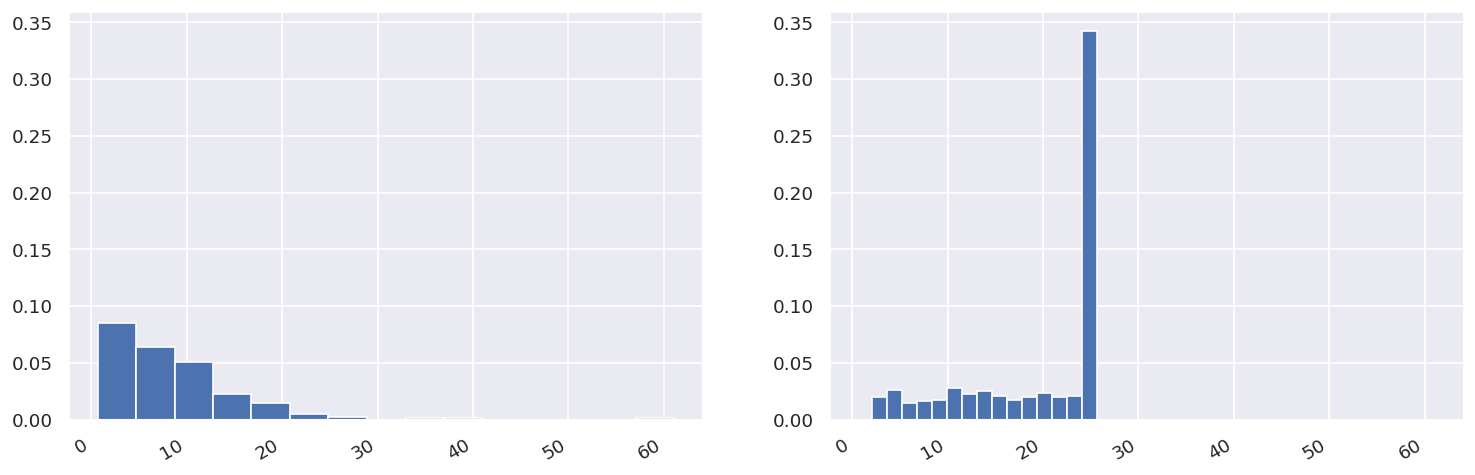

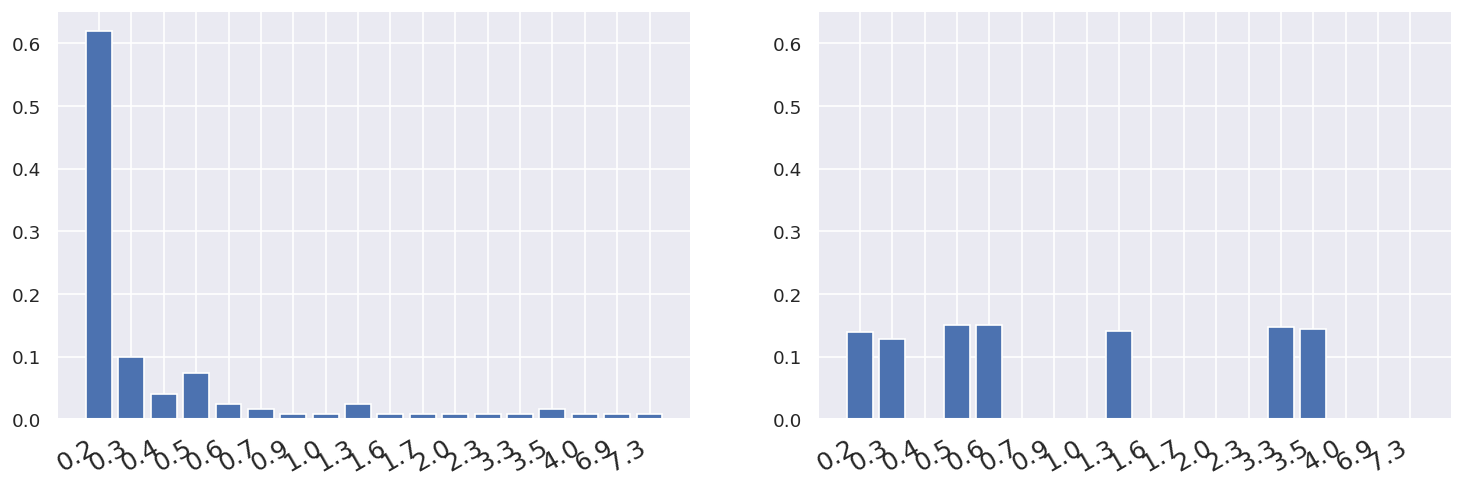

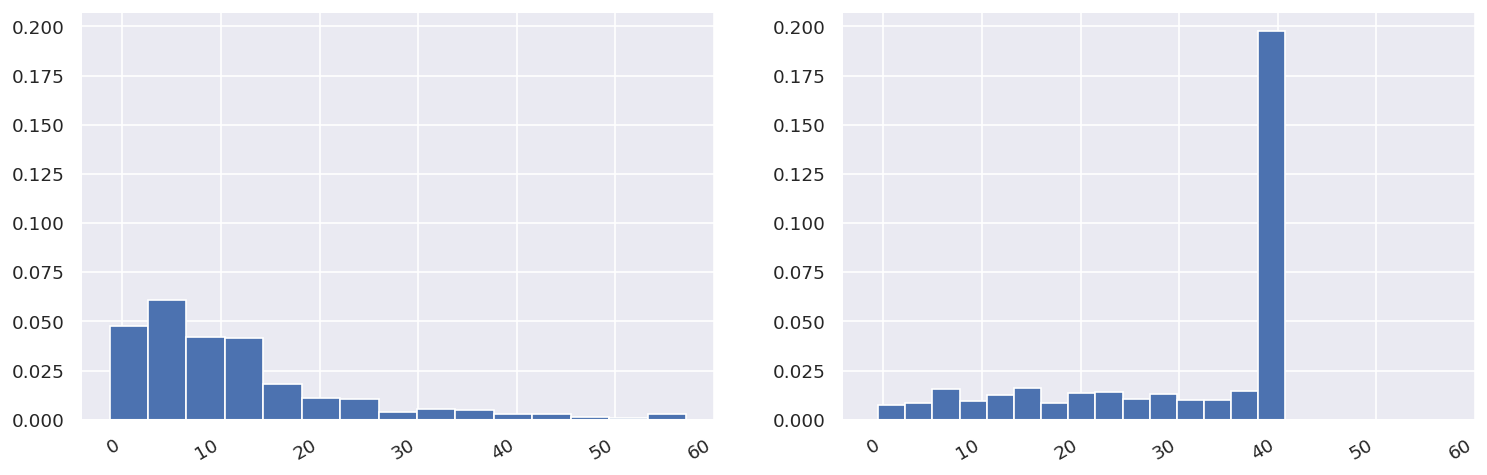

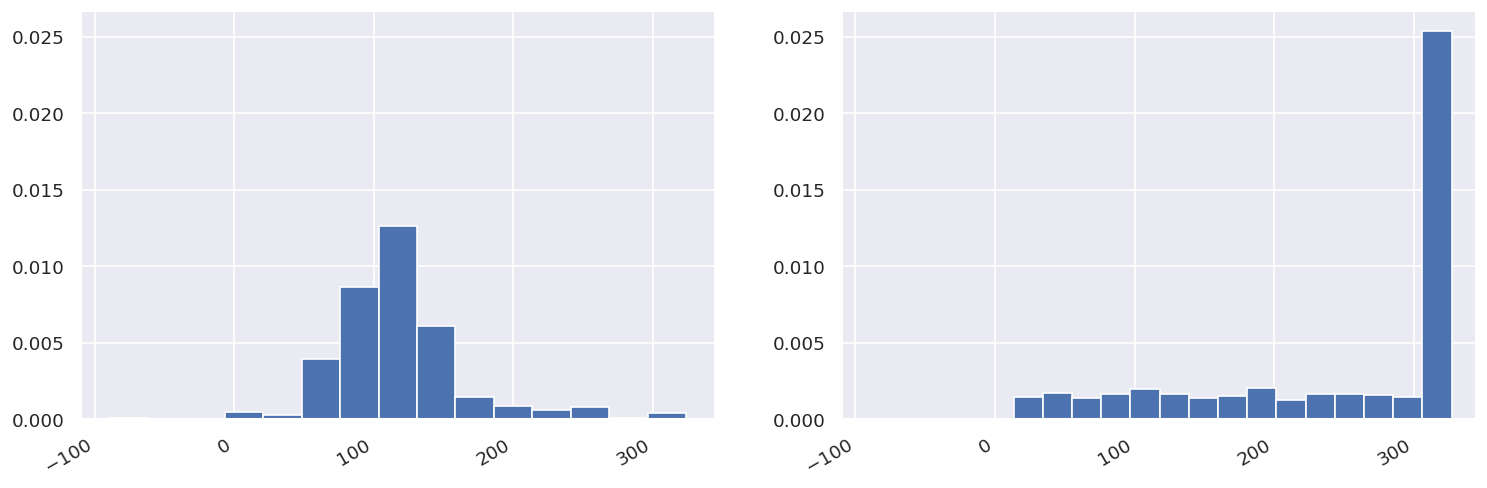

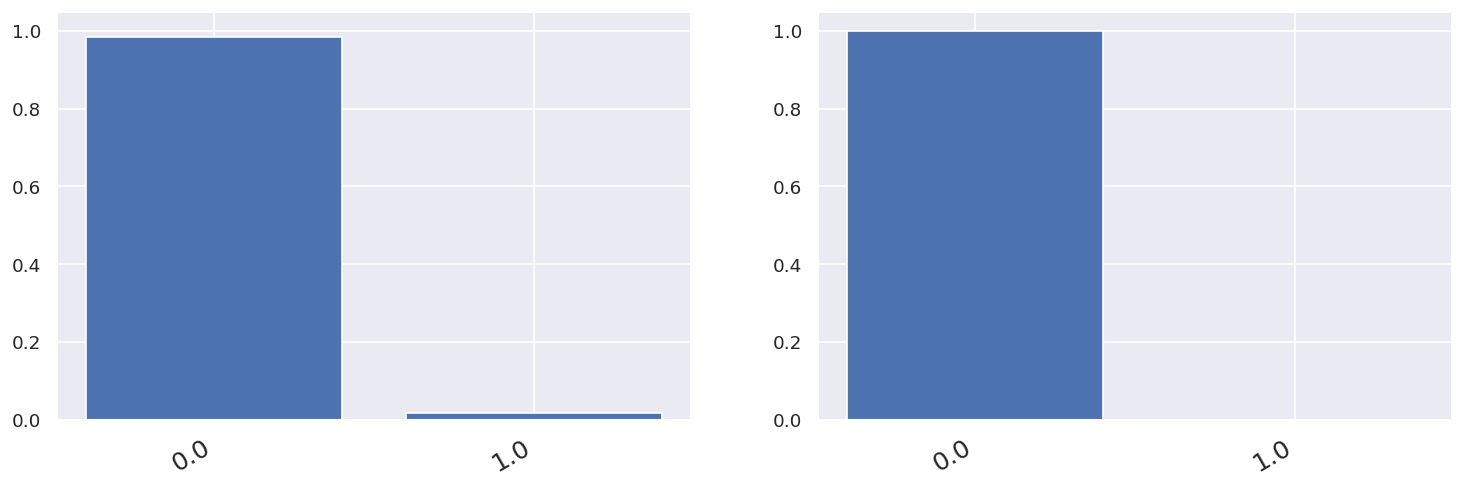

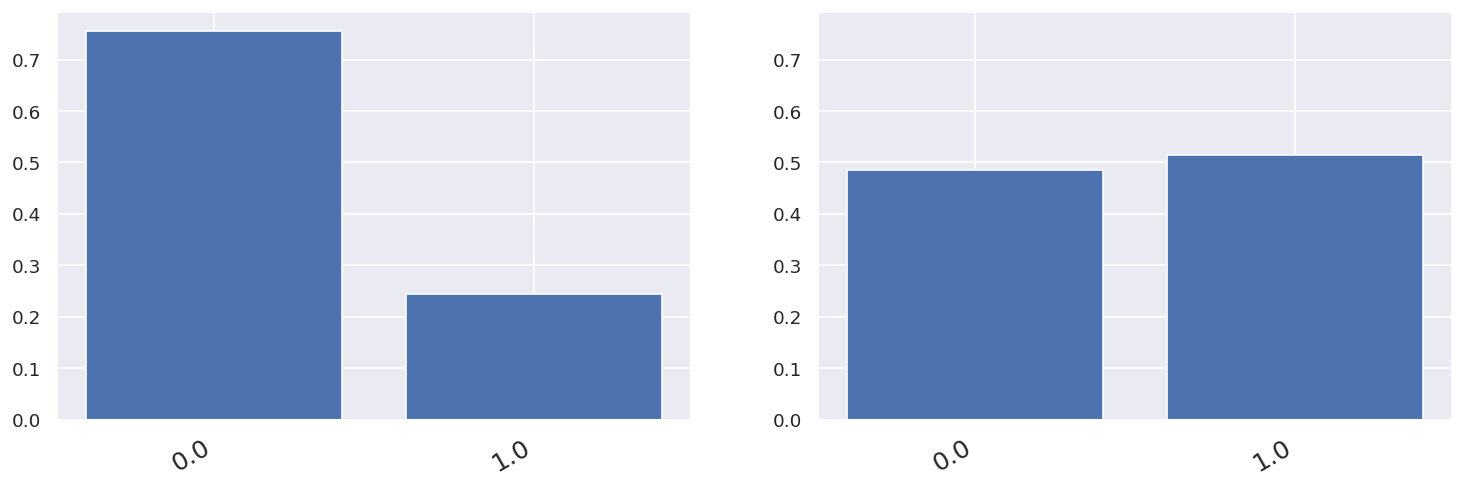

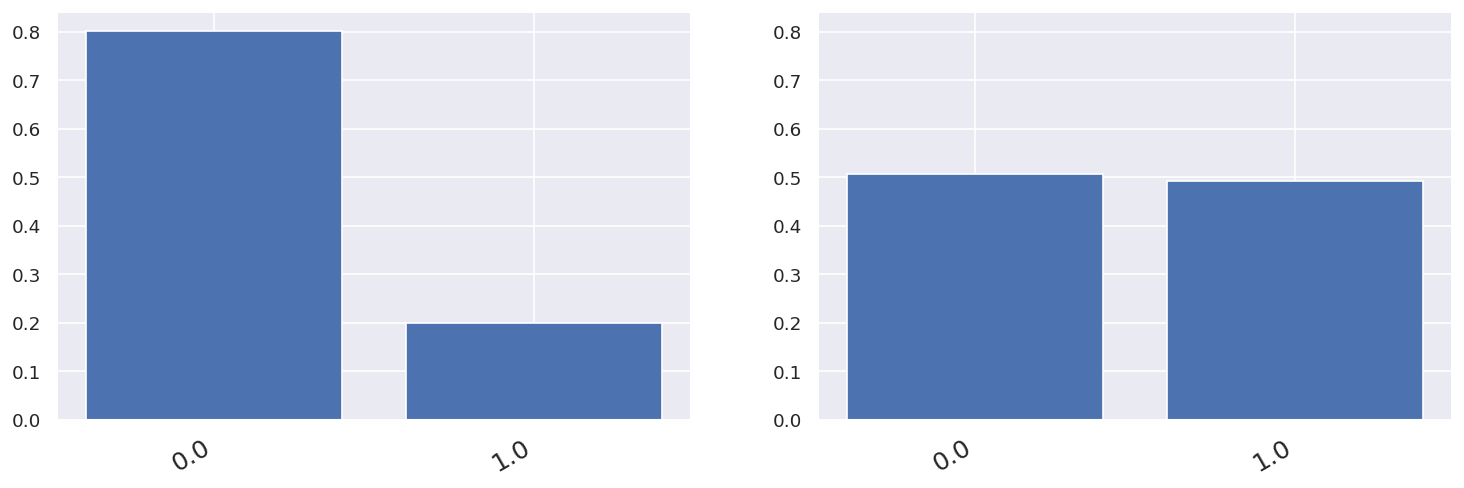

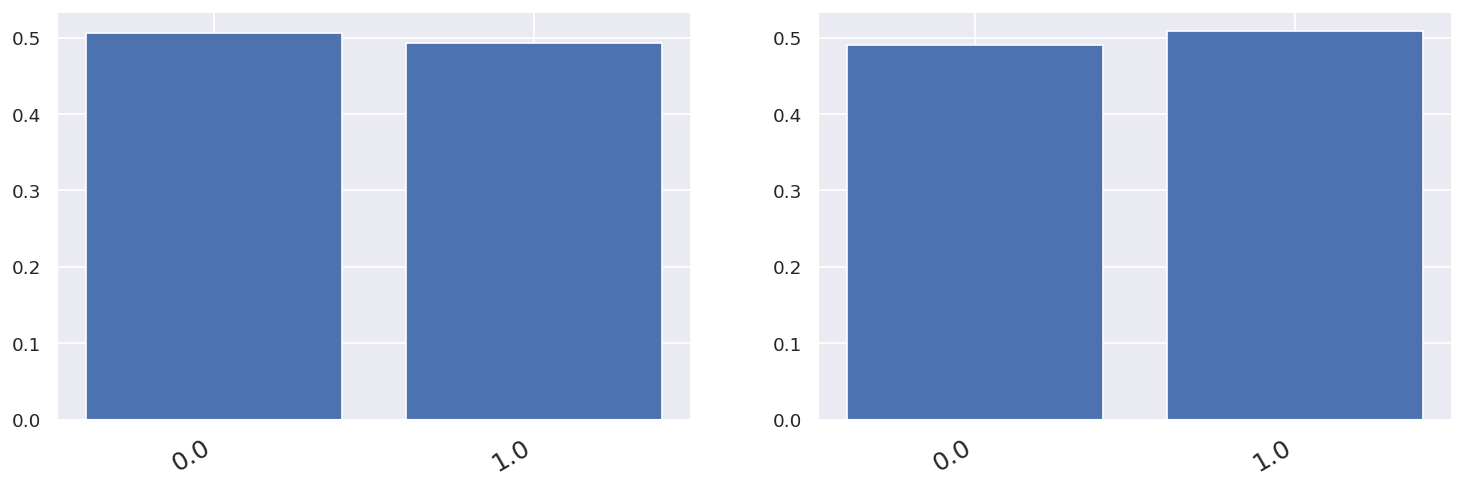

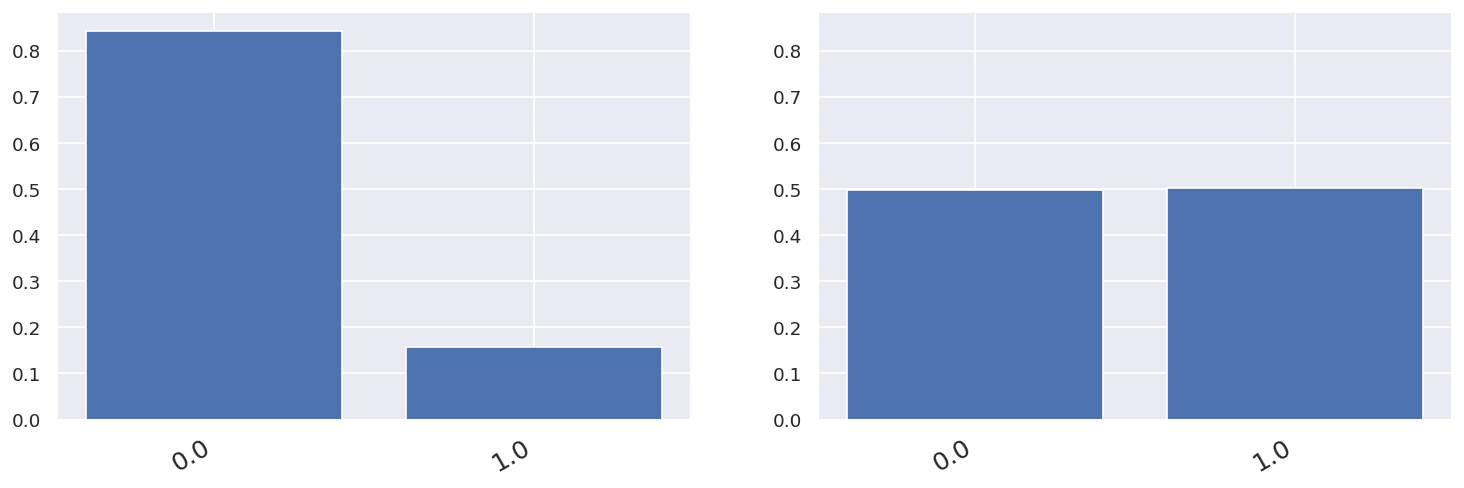

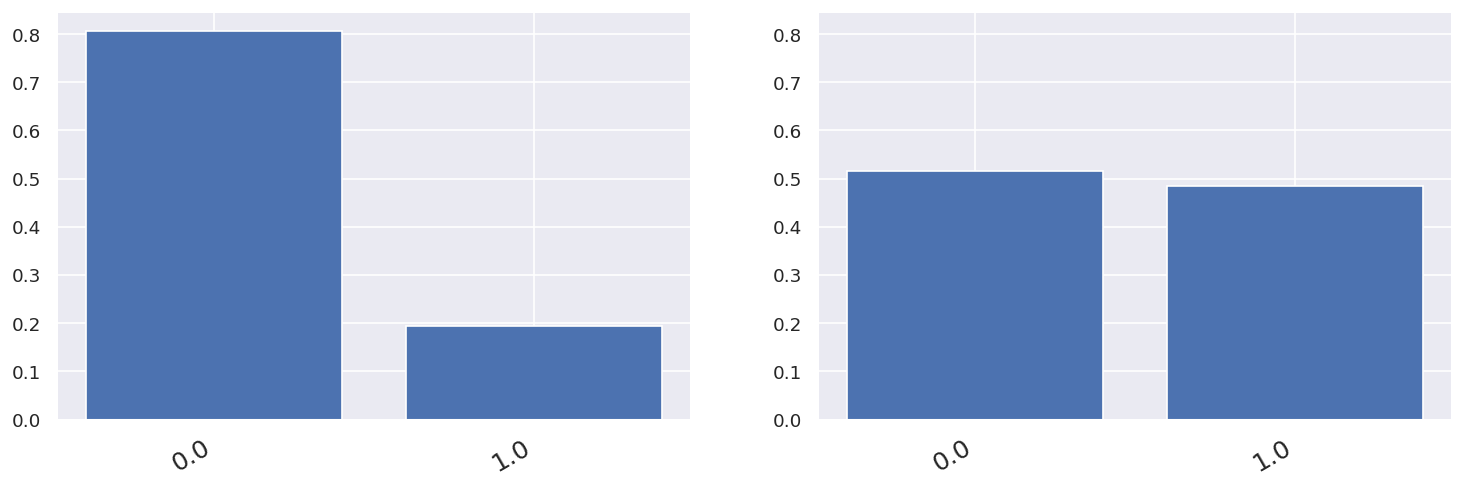

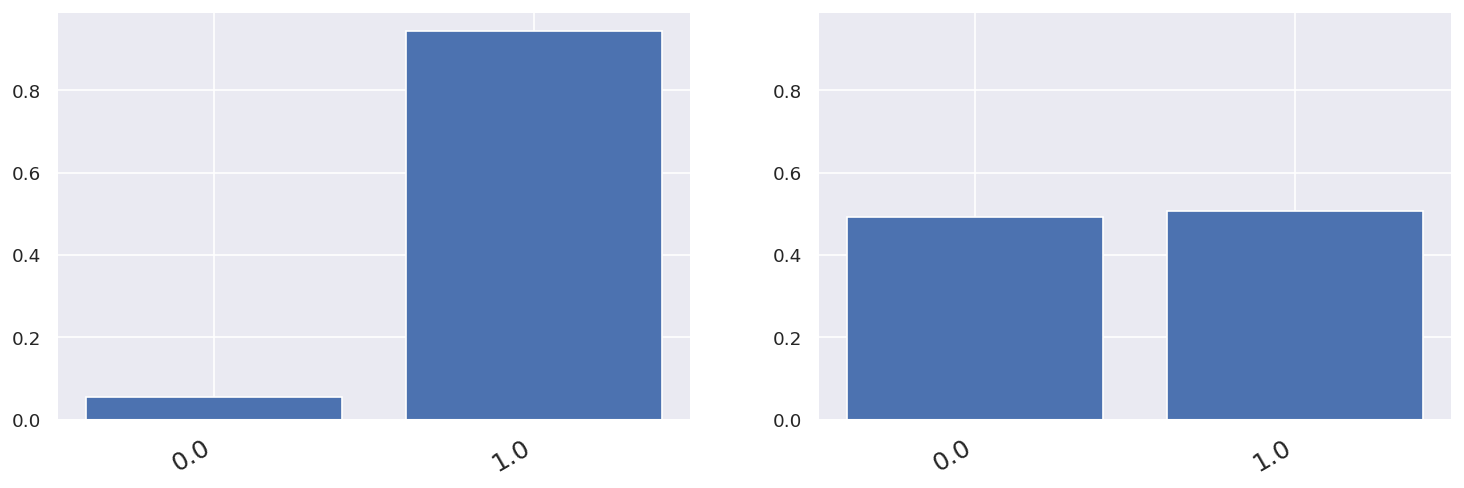

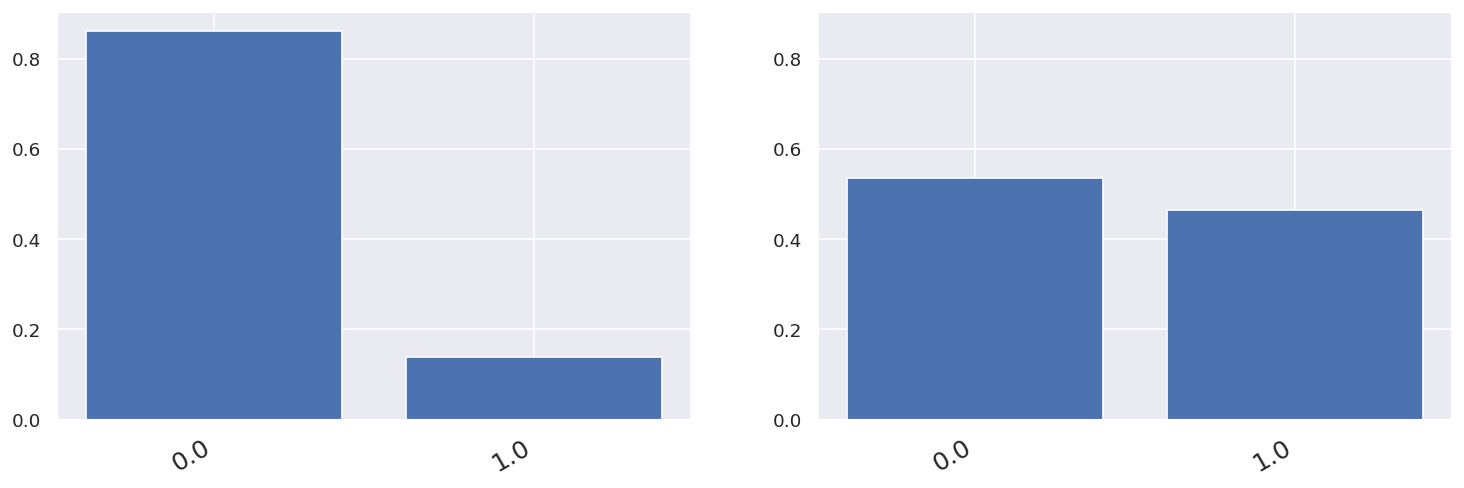

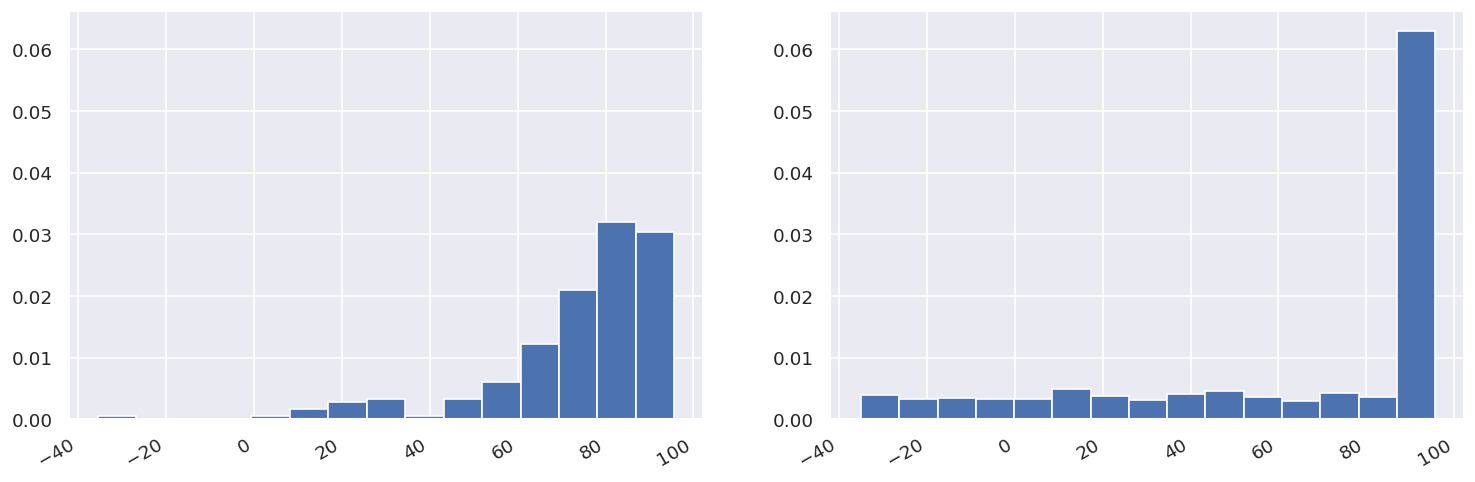

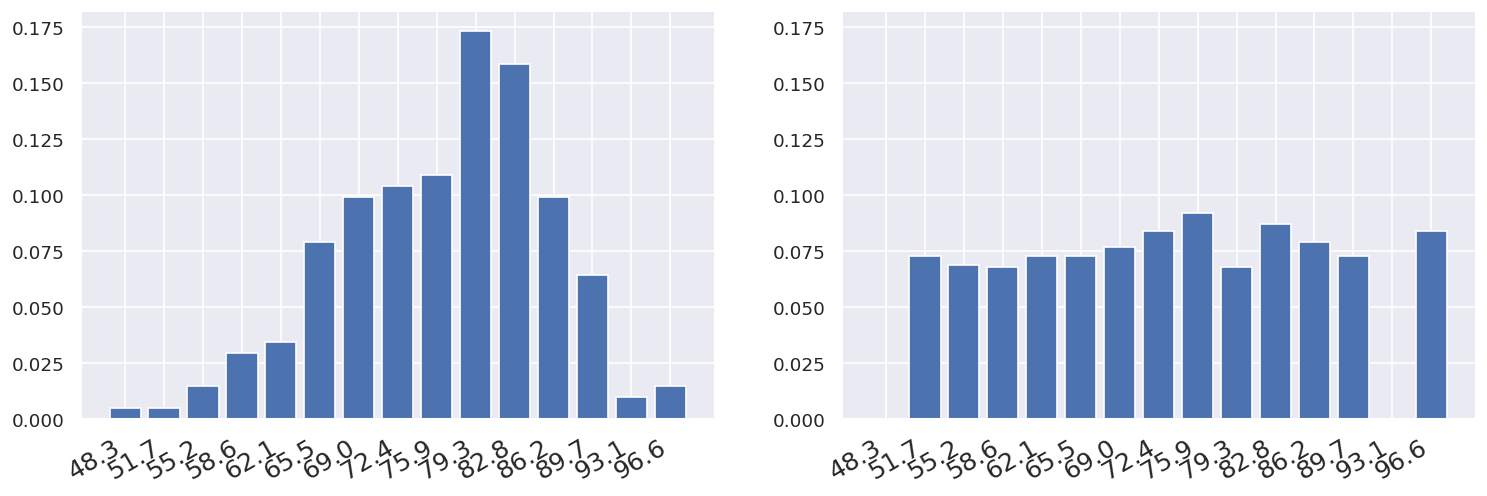

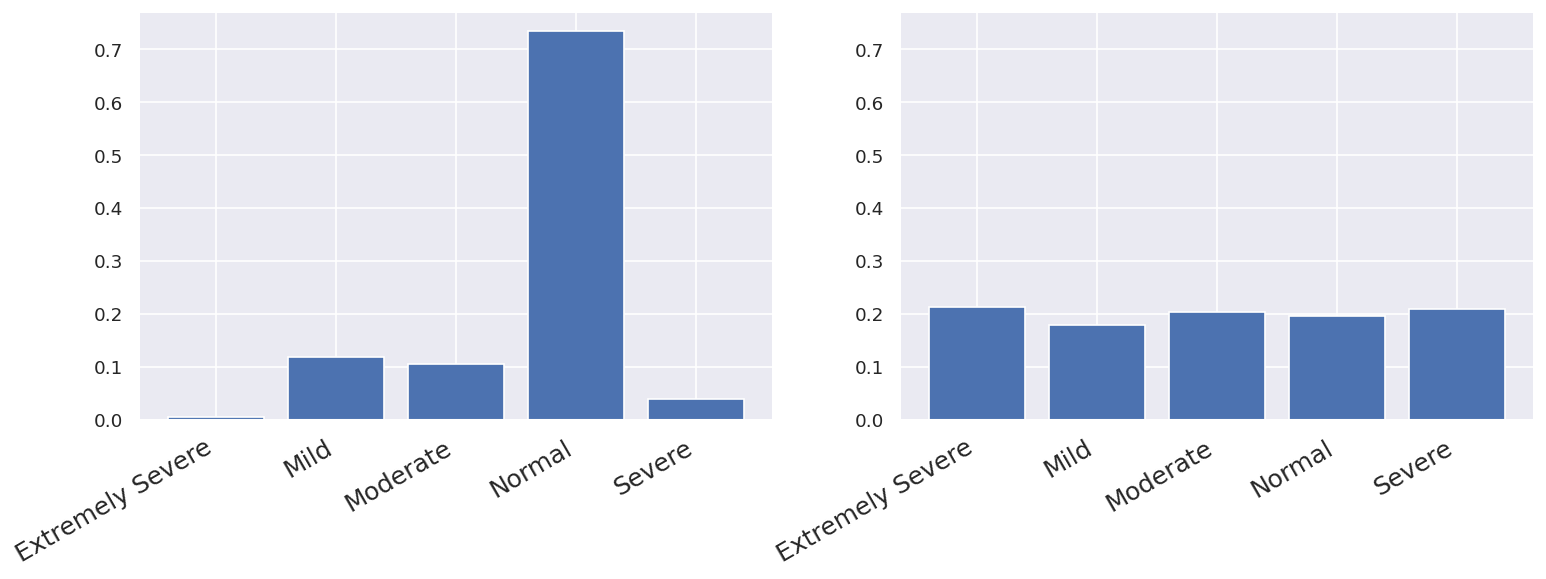

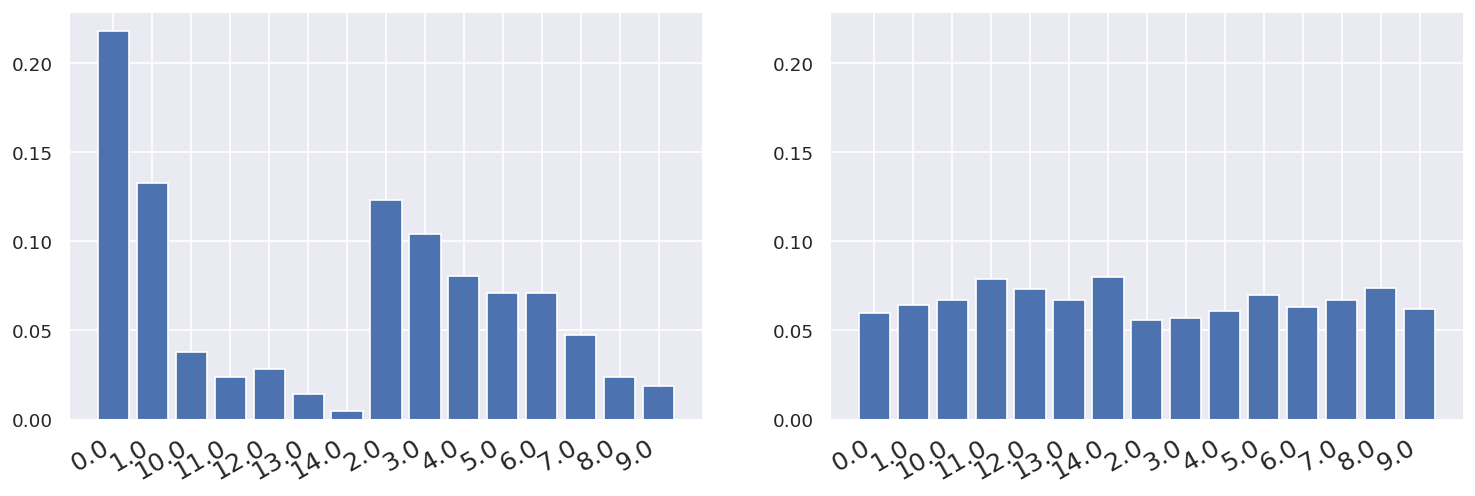

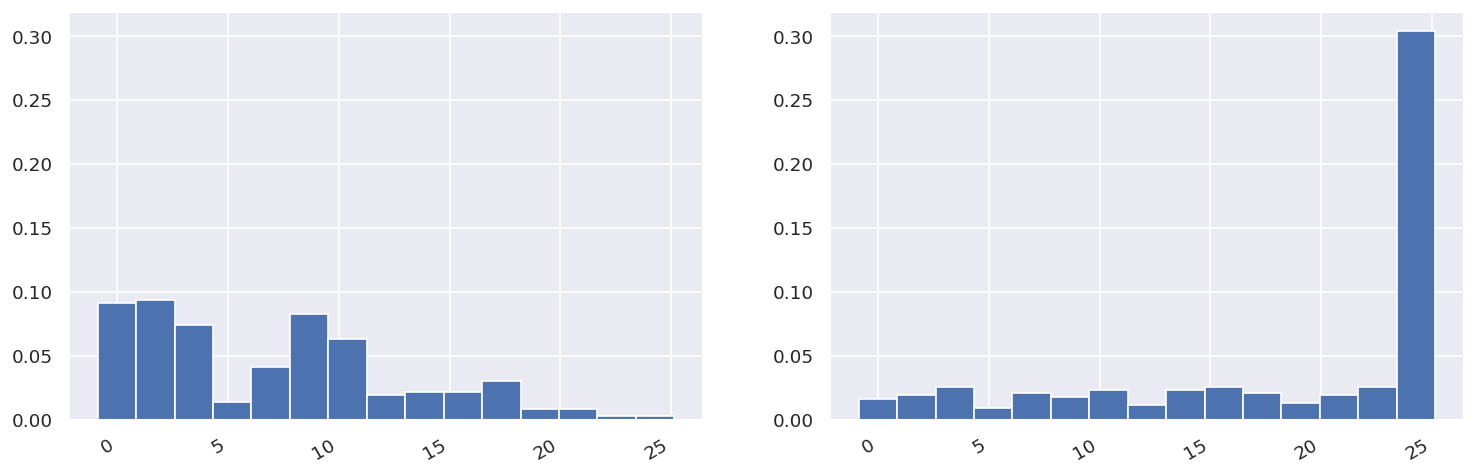

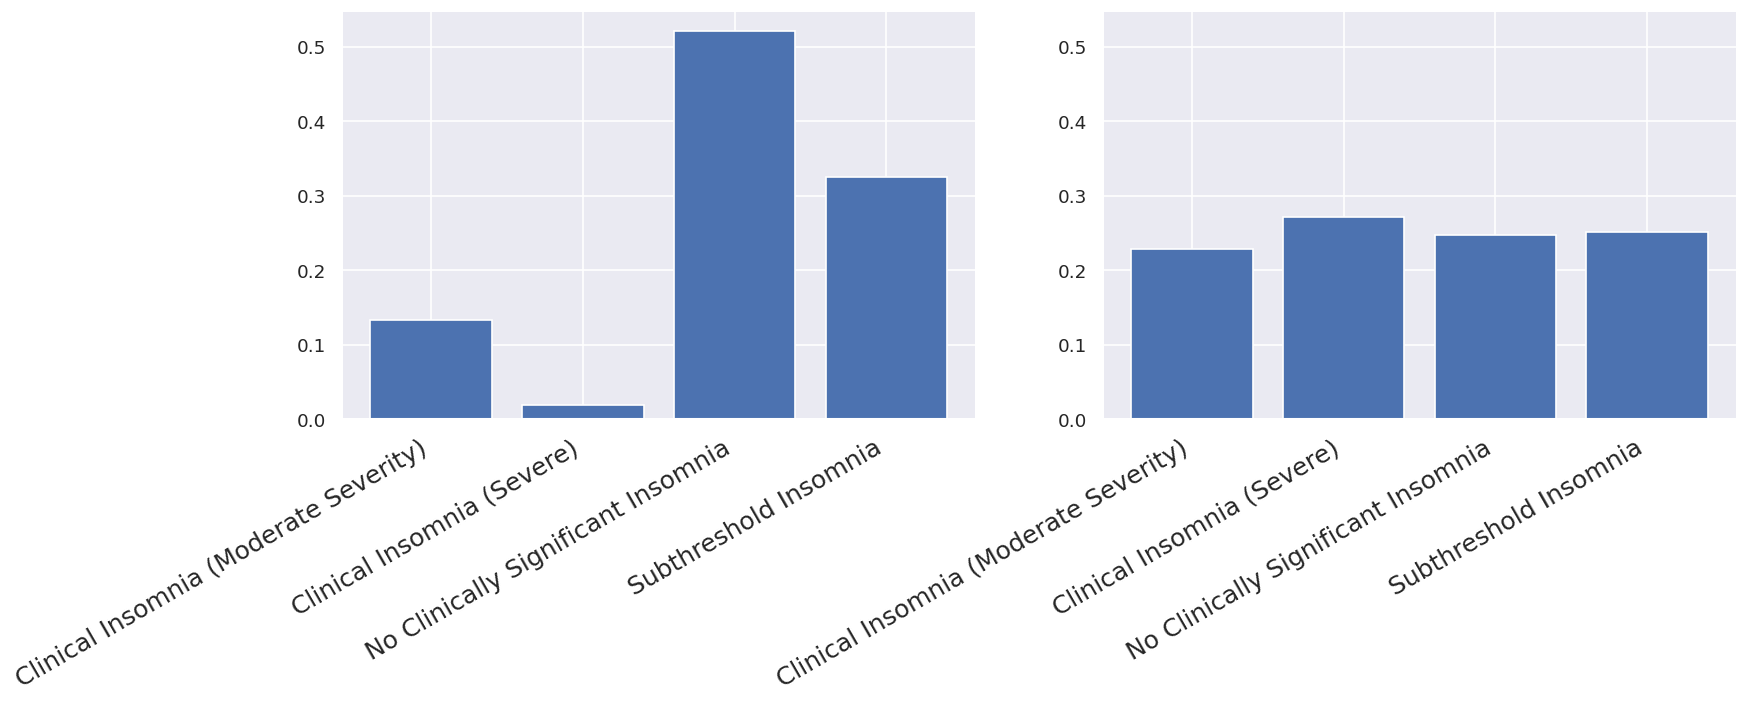

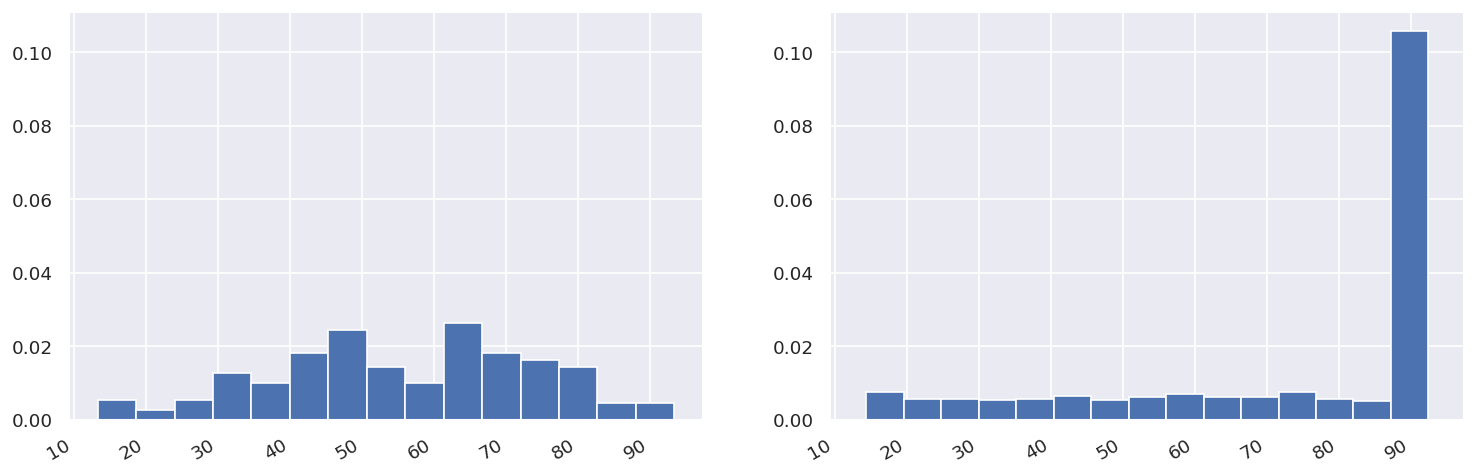

In [20]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

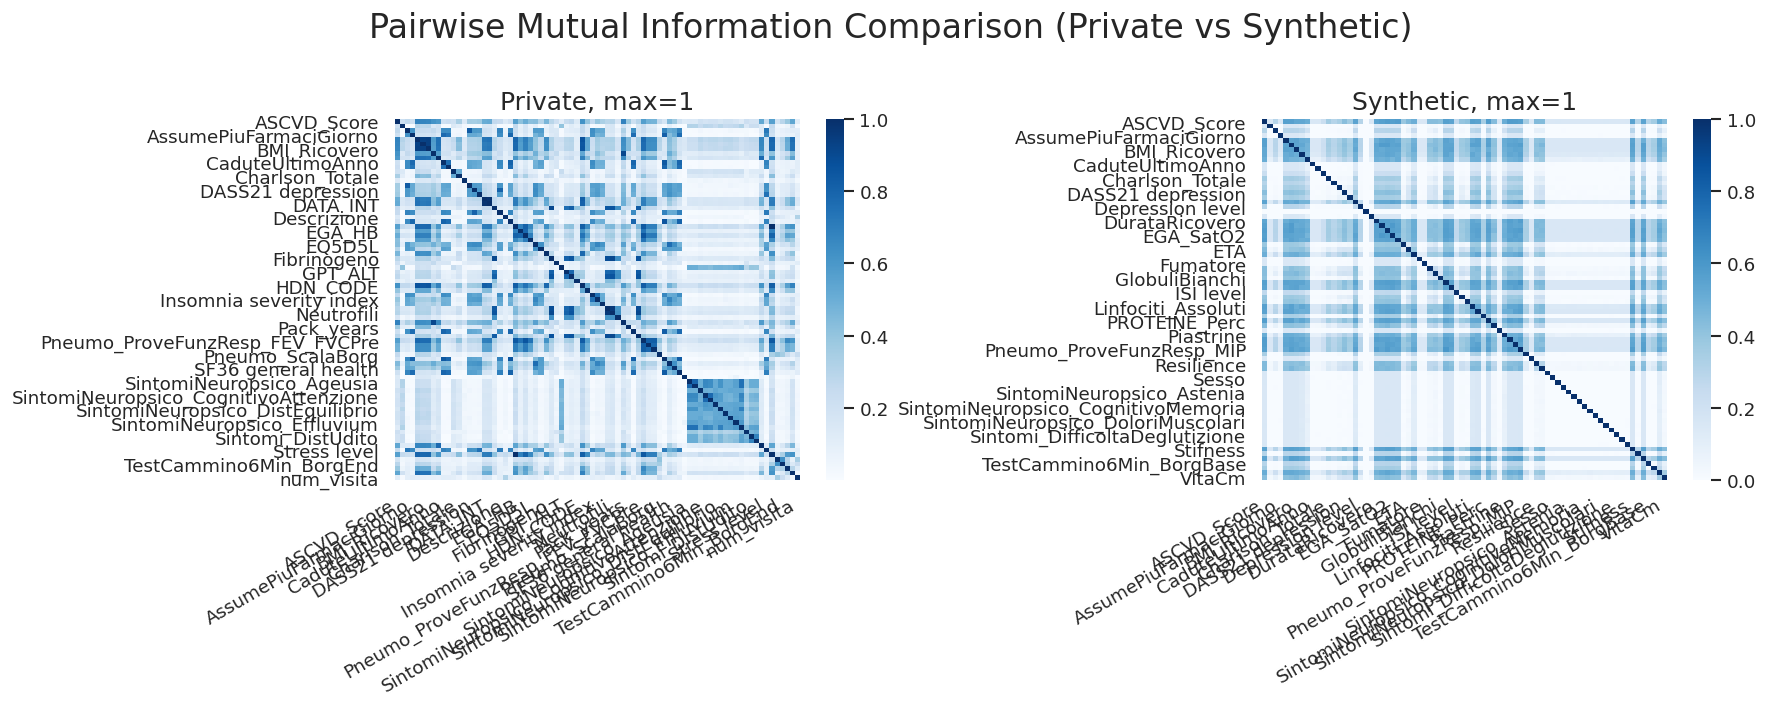

In [21]:
inspector.mutual_information_heatmap()

In [22]:
synthetic_df.head()

HDN_CODE Sesso   ETA  ASCVD_Score  Charlson_Totale  \
0  9427785.0     F  86.0     9.391105              1.0   
1  9427785.0     M  73.0    48.810000              4.0   
2  9427785.0     M  86.0    48.810000              3.0   
3  9427785.0     F  69.0    48.810000              1.0   
4  4821281.0     M  86.0    48.810000              2.0   

          Charlson_Diabete   Stifness    CAP  FrailtyPhenotypeBool    EGA_HB  \
0  1 = Senza complicazioni   5.126472  400.0                   0.0  17.50000   
1                   0 = No  16.664881  400.0                   0.0  17.50000   
2                   0 = No  20.200000  400.0                   1.0  17.50000   
3  1 = Senza complicazioni  20.200000  400.0                   0.0  15.60252   
4                   0 = No  19.097644  109.0                   0.0  11.79868   

   ...  DASS21 stress      Stress level  DASS21 anxiety     Anxiety level  \
0  ...           17.0            Normal            15.0            Severe   
1  ...           15.0              Mild             1.0              Mild   
2  ...           17.0              Mild             8.0  Extremely Severe   
3  ...           17.0  Extremely Severe            10.0          Moderate   
4  ...            2.0          Moderate            15.0              Mild   

   DASS21 depression  Depression level Insomnia severity index  \
0               11.0            Severe                    19.0   
1                7.0            Severe                    16.0   
2               13.0            Severe                    18.0   
3                2.0  Extremely Severe                     4.0   
4                5.0            Severe                    17.0   

                               ISI level  SF36 general health  Resilience  
0  Clinical Insomnia (Moderate Severity)                 75.0        26.0  
1     No Clinically Significant Insomnia                100.0        95.0  
2  Clinical Insomnia (Moderate Severity)                100.0        50.0  
3             Clinical Insomnia (Severe)                100.0        95.0  
4                  Subthreshold Insomnia                100.0        31.0  

[5 rows x 76 columns]

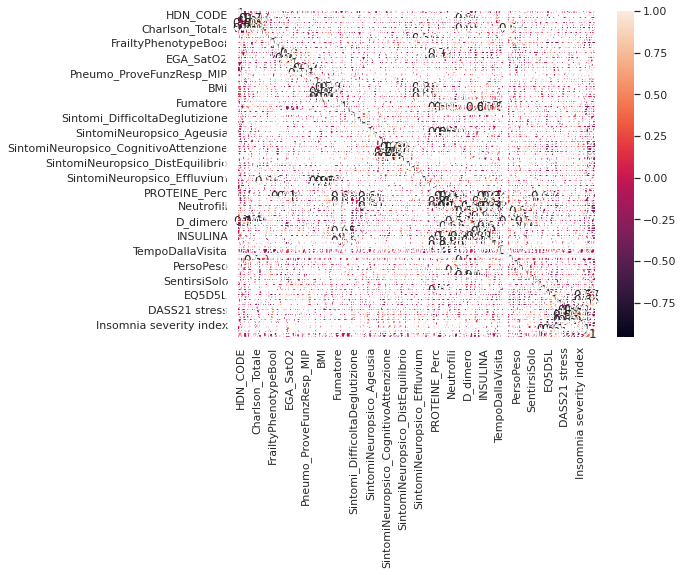

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(dfSenzaData.corr(), annot=True)
plt.show()